In [27]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM, AutoModelForImageTextToText, pipeline
from huggingface_hub import login
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.corpus import stopwords
from nltk.util import ngrams
import nltk
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from tqdm import tqdm, auto as tqdm_auto
from collections import Counter
from typing import TypedDict, Optional
from IPython.display import Image
import whisper
import librosa
import os
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from langgraph.graph import StateGraph, END
from langchain_core.runnables.graph import MermaidDrawMethod
import requests
import tarfile
import torch
from dotenv import load_dotenv
from transformers import logging
logging.set_verbosity_error()
from bert_score import score
from scipy.stats import mannwhitneyu
import itertools

# 1. Read Data

In [2]:
# adjust display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
# URL for the dev-clean dataset
url = "https://www.openslr.org/resources/12/dev-clean.tar.gz"
dataset_dir = "Data/"
tar_path = os.path.join(dataset_dir, "dev-clean.tar.gz")


os.makedirs(dataset_dir, exist_ok=True)

# Download the dataset 
if not os.path.exists(tar_path):
    print(f"Downloading {url}...")
    response = requests.get(url, stream=True)
    with open(tar_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            f.write(chunk)
    print("Download completed.")

# Extract the dataset
extract_path = os.path.join(dataset_dir, "LibriSpeech")  # Base directory
if not os.path.exists(extract_path):
    print(f"Extracting {tar_path}...")
    with tarfile.open(tar_path, "r:gz") as tar:
        # Extract all directly into the base directory without nested folder
        tar.extractall(path=dataset_dir)
    print(f"Extraction completed. Data available at {extract_path}")


In [5]:
# Fix nested structure
nested_path = os.path.join(dataset_dir, "LibriSpeech", "LibriSpeech")
if os.path.exists(nested_path):
    print("Fixing nested folder structure...")
    for item in os.listdir(nested_path):
        source = os.path.join(nested_path, item)
        destination = os.path.join(dataset_dir, "LibriSpeech", item)
        if os.path.isdir(source):
            shutil.move(source, destination)
        else:
            shutil.copy(source, destination)
    # Remove the redundant nested folder
    shutil.rmtree(nested_path)
    print("Structure fixed.")


In [6]:
dev_clean_path = os.path.join(dataset_dir, "LibriSpeech", "dev-clean")

def get_audio_paths(root_dir):
    audio_paths = []
    for dirpath, _, filenames in os.walk(root_dir):
        for file in filenames:
            if file.endswith(".flac"):
                full_path = os.path.join(dirpath, file)
                audio_paths.append(full_path)
    return audio_paths

# Get audio paths for dev-clean
audio_paths = get_audio_paths(dev_clean_path)

print(f"Number of audio files found in dev-clean: {len(audio_paths)}")
print(audio_paths[:5])  # Display the first 5 paths for verification


Number of audio files found in dev-clean: 2703
['Data/LibriSpeech/dev-clean/2412/153954/2412-153954-0019.flac', 'Data/LibriSpeech/dev-clean/2412/153954/2412-153954-0023.flac', 'Data/LibriSpeech/dev-clean/2412/153954/2412-153954-0015.flac', 'Data/LibriSpeech/dev-clean/2412/153954/2412-153954-0003.flac', 'Data/LibriSpeech/dev-clean/2412/153954/2412-153954-0002.flac']


In [7]:
def get_transcript(flac_path):
    """Extracts the transcript text for a given .flac file."""
    dir_path = os.path.dirname(flac_path)
    file_id = os.path.splitext(os.path.basename(flac_path))[0]
    trans_file = os.path.join(dir_path, f"{file_id.split('-')[0]}-{file_id.split('-')[1]}.trans.txt")
    
    # Read the .trans.txt file only once per directory
    if os.path.exists(trans_file):
        with open(trans_file, "r") as f:
            lines = f.readlines()
        transcripts = {line.split(" ", 1)[0]: line.split(" ", 1)[1].strip() for line in lines}
        return transcripts.get(file_id, "")
    return ""

In [8]:
def get_audio_data(root_dir):
    """Generate data with file path, duration, and transcript."""
    audio_paths = get_audio_paths(root_dir)
    data = []

    for path in audio_paths:
        duration = librosa.get_duration(filename=path)
        transcript = get_transcript(path)
        data.append({'file': path, 'duration': duration, 'text': transcript})
    
    return pd.DataFrame(data)

# Path to dev-clean directory
dev_clean_path = os.path.join("Data", "LibriSpeech", "dev-clean")

data = get_audio_data(dev_clean_path)
print(data.head())

/var/folders/wt/tg6zmlg51zgby6_gsdtq6tpw0000gn/T/ipykernel_29083/1680055573.py:7: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=path)


                                                           file  duration  \
0  Data/LibriSpeech/dev-clean/2412/153954/2412-153954-0019.flac     7.485   
1  Data/LibriSpeech/dev-clean/2412/153954/2412-153954-0023.flac     2.650   
2  Data/LibriSpeech/dev-clean/2412/153954/2412-153954-0015.flac    11.390   
3  Data/LibriSpeech/dev-clean/2412/153954/2412-153954-0003.flac     8.150   
4  Data/LibriSpeech/dev-clean/2412/153954/2412-153954-0002.flac     4.055   

                                                                                                                                                                                                       text  
0                                                                BUT BY AND BY THEY CAME TO MY WATCH WHICH I HAD HIDDEN AWAY IN THE INMOST POCKET THAT I HAD AND HAD FORGOTTEN WHEN THEY BEGAN THEIR SEARCH  
1                                                                                                                            

# 2. Exploratory Data Analysis

In [9]:
# Check for missing values
print(data.isnull().sum())


file        0
duration    0
text        0
dtype: int64


In [10]:
# Check for duplicates
duplicates = data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Number of duplicate rows: 0


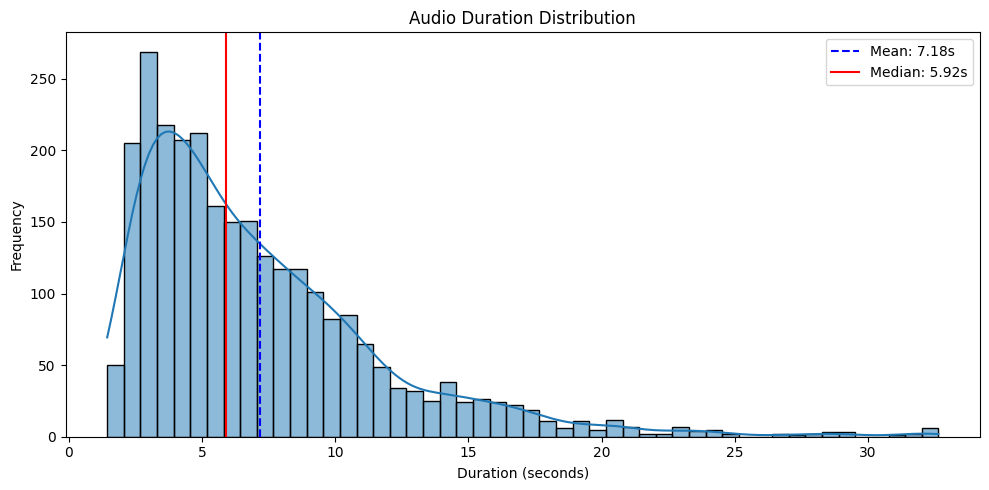

In [11]:
# histogram of audio durations
mean_duration = data['duration'].mean()
median_duration = data['duration'].median()

plt.figure(figsize=(10, 5))
sns.histplot(data['duration'], bins=50, kde=True)

plt.axvline(mean_duration, color='blue', linestyle='--', label=f'Mean: {mean_duration:.2f}s')
plt.axvline(median_duration, color='red', linestyle='-', label=f'Median: {median_duration:.2f}s')

plt.title('Audio Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

In [12]:
# Calculate descriptive statistics
mean_duration = data["duration"].mean()
median_duration = data["duration"].median()
std_duration = data["duration"].std()

print(f"Mean Duration: {mean_duration:.2f} seconds")
print(f"Median Duration: {median_duration:.2f} seconds")
print(f"Standard Deviation: {std_duration:.2f} seconds")

Mean Duration: 7.18 seconds
Median Duration: 5.92 seconds
Standard Deviation: 4.70 seconds


- The distribution of audio durations is heavily right-skewed, indicating that the majority of audio segments are relatively short.

- The highest frequency of segments is concentrated in the 0 to 5 seconds range, suggesting that most audio files are brief and concise.

        word_count   char_count
count  2703.000000  2703.000000
mean     20.126526   106.716981
std      13.524448    73.947954
min       1.000000     3.000000
25%      10.000000    52.000000
50%      17.000000    89.000000
75%      26.000000   139.000000
max      92.000000   516.000000


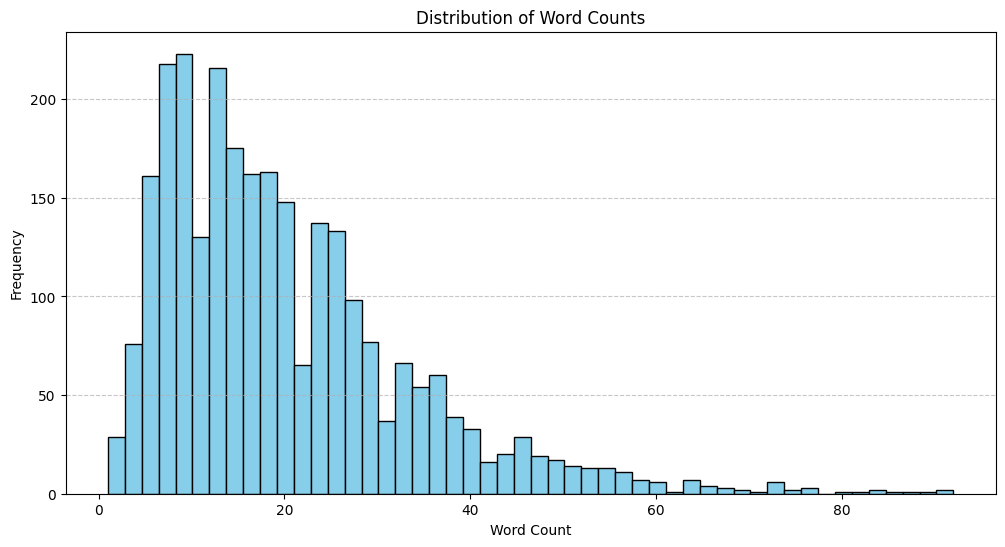

In [15]:
# Calculate word and character counts for each transcription
data["word_count"] = data["text"].apply(lambda x: len(str(x).split()))
data["char_count"] = data["text"].apply(lambda x: len(str(x)))

# Display basic statistics
print(data[["word_count", "char_count"]].describe())

# Plot Word Count Distribution
plt.figure(figsize=(12, 6))
plt.hist(data["word_count"], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [16]:
# use bert model to compute token length of text
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
data['token_length'] = data['text'].apply(lambda x: len(tokenizer.tokenize(x)))

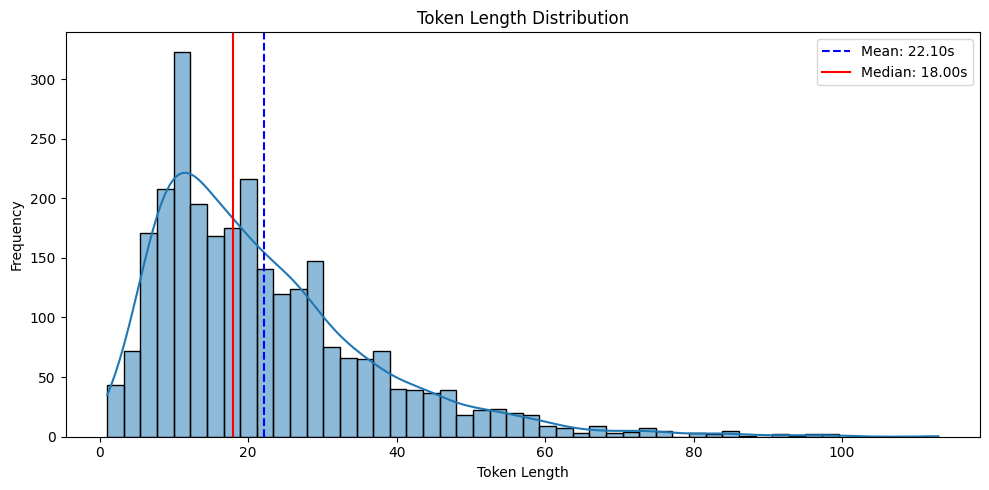

In [17]:
# histogram of token lengths
mean_token_length = data['token_length'].mean()
median_token_length = data['token_length'].median()

plt.figure(figsize=(10, 5))
sns.histplot(data['token_length'], bins=50, kde=True)

plt.axvline(mean_token_length, color='blue', linestyle='--', label=f'Mean: {mean_token_length:.2f}s')
plt.axvline(median_token_length, color='red', linestyle='-', label=f'Median: {median_token_length:.2f}s')

plt.title('Token Length Distribution')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

# 3. Audio to Text

In [19]:
# # use OpenAI Whisper model
# model = whisper.load_model("base")
# transcriptions = []

# # Loop through each file and transcribe
# for path in tqdm(data['file'], desc="Transcribing audio"):
#     try:
#         result = model.transcribe(path)
#         transcriptions.append(result['text'])
#     except Exception as e:
#         print(f"Error transcribing {path}: {e}")
#         transcriptions.append("")

# # Add transcriptions to DataFrame
# data['whisper_text'] = transcriptions

In [ ]:
# data.to_csv("data/dev_clean.csv", index=False)

In [ ]:
data = pd.read_csv("data/dev_clean.csv")

In [4]:
data.head()

,file,duration,text,token_length,whisper_text
0,Data/dev-clean/dev-clean/2412/153954/2412-153954-0019.flac,7.485,BUT BY AND BY THEY CAME TO MY WATCH WHICH I HAD HIDDEN AWAY IN THE INMOST POCKET THAT I HAD AND HAD FORGOTTEN WHEN THEY BEGAN THEIR SEARCH,30,"But by and by they came to my watch, which I had hidden away in the inn most pocket that I had and had forgotten when they began their search."
1,Data/dev-clean/dev-clean/2412/153954/2412-153954-0023.flac,2.650,THIS HAD SOME EFFECT IN CALMING HIM,7,This had some effect in calming him.
2,Data/dev-clean/dev-clean/2412/153954/2412-153954-0015.flac,11.390,SUFFICE IT THAT I FOUND MYSELF TAKEN BEFORE THE CHIEF MAGISTRATE AND BY HIS ORDERS WAS PLACED IN AN APARTMENT WITH TWO OTHER PEOPLE WHO WERE THE FIRST I HAD SEEN LOOKING ANYTHING BUT WELL AND HANDSOME,39,"Suffice it that I found myself taken before the chief magistrate, and by his orders was placed in an apartment with two other people. Who were the first I had seen looking anything but well in handsome."
3,Data/dev-clean/dev-clean/2412/153954/2412-153954-0003.flac,8.150,THE VINE GREW OUTSIDE MANY OF THE HOUSES AND THERE WERE SOME WITH SIGN BOARDS ON WHICH WAS PAINTED A BOTTLE AND A GLASS THAT MADE ME FEEL MUCH AT HOME,31,The vine grew outside many of the houses and there were some with signboards on which was painted a bottle and a glass that made me feel much at home
4,Data/dev-clean/dev-clean/2412/153954/2412-153954-0002.flac,4.055,THE STREETS WERE NARROW AND UNPAVED BUT VERY FAIRLY CLEAN,12,The streets were narrow and unpaid but very fairly clean.


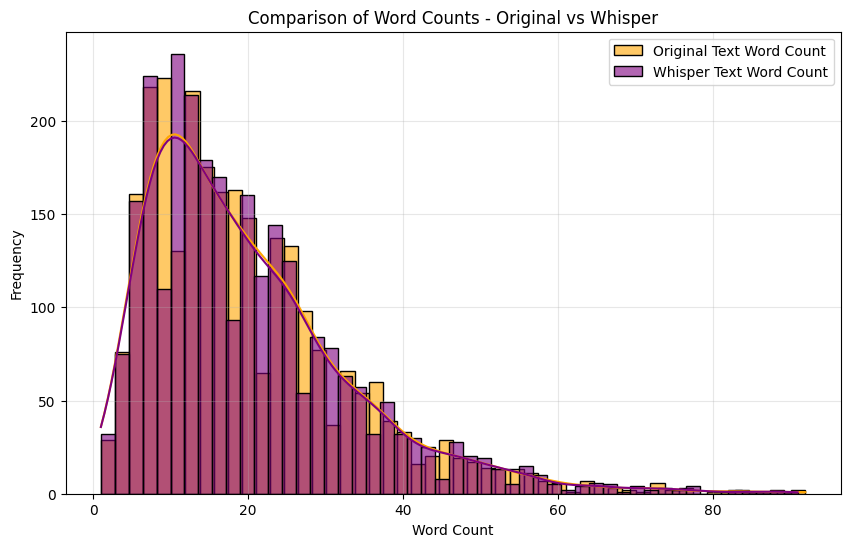

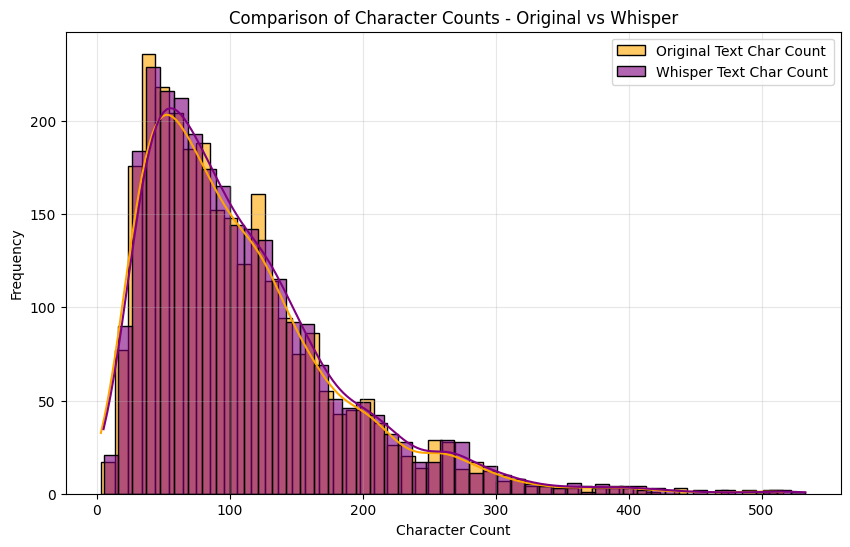

In [24]:
#  Word and Character Counts for Original Text
data["text_word_count"] = data["text"].apply(lambda x: len(str(x).split()))
data["text_char_count"] = data["text"].apply(lambda x: len(str(x)))

#  Word and Character Counts for Whisper Text
data["whisper_word_count"] = data["whisper_text"].apply(lambda x: len(str(x).split()))
data["whisper_char_count"] = data["whisper_text"].apply(lambda x: len(str(x)))

#  Comparison of Word Counts
plt.figure(figsize=(10, 6))
sns.histplot(data["text_word_count"], bins=50, color='orange', label="Original Text Word Count", kde=True, alpha=0.6)
sns.histplot(data["whisper_word_count"], bins=50, color='purple', label="Whisper Text Word Count", kde=True, alpha=0.6)
plt.title("Comparison of Word Counts - Original vs Whisper")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#  Comparison of Character Counts
plt.figure(figsize=(10, 6))
sns.histplot(data["text_char_count"], bins=50, color='orange', label="Original Text Char Count", kde=True, alpha=0.6)
sns.histplot(data["whisper_char_count"], bins=50, color='purple', label="Whisper Text Char Count", kde=True, alpha=0.6)
plt.title("Comparison of Character Counts - Original vs Whisper")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


- From the above chart- the word and character count distributions for both the original text and Whisper text are closely aligned, indicating that Whisper generally preserves the length of the transcriptions, with minor variations observed in specific ranges.
- The majority of audio segments contain 10-30 words and 50-150 characters, indicating that most files are brief, consisting of single sentences or short phrases.

- Also given the short duration of each audio file (5s to 10s), generating meaningful summaries is impractical as the content is too brief to provide substantial context or insights.

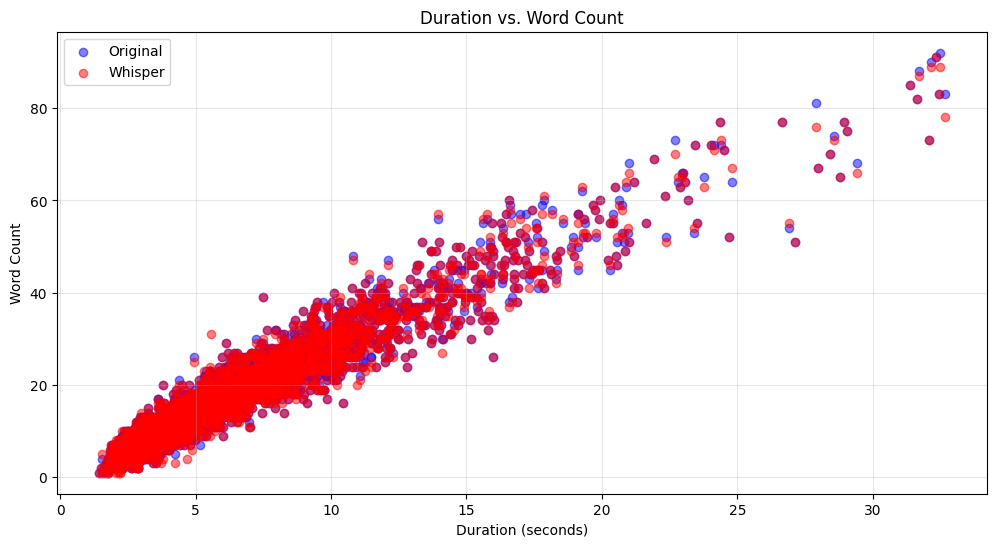

Correlation between Duration and Original Word Count: 0.96
Correlation between Duration and Whisper Word Count: 0.96


In [25]:
# Scatter Plot: Duration vs. Word Count
plt.figure(figsize=(12, 6))
plt.scatter(data["duration"], data["text_word_count"], alpha=0.5, label="Original", color='blue')
plt.scatter(data["duration"], data["whisper_word_count"], alpha=0.5, label="Whisper", color='red')
plt.title("Duration vs. Word Count")
plt.xlabel("Duration (seconds)")
plt.ylabel("Word Count")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Correlation Analysis
correlation = data["duration"].corr(data["text_word_count"])
print(f"Correlation between Duration and Original Word Count: {correlation:.2f}")

correlation_whisper = data["duration"].corr(data["whisper_word_count"])
print(f"Correlation between Duration and Whisper Word Count: {correlation_whisper:.2f}")


Top 20 common words: [('the', 3497), ('and', 1939), ('of', 1742), ('to', 1379), ('a', 1202), ('in', 935), ('was', 684), ('he', 684), ('i', 677), ('that', 667), ('it', 662), ('his', 585), ('with', 474), ('had', 441), ('as', 410), ('for', 404), ('is', 382), ('you', 372), ('but', 344), ('not', 342)]


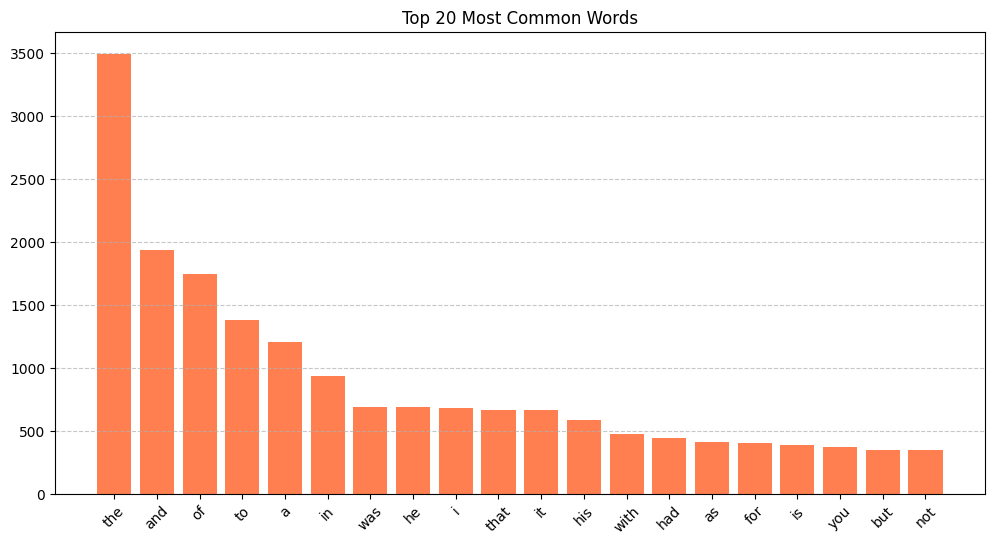

In [26]:
# Identifying the most common words to  understand the general content or context of the dataset.
all_text = " ".join(data["whisper_text"].dropna().tolist()).lower()

# Tokenize and count words
words = re.findall(r'\b\w+\b', all_text)
word_counts = Counter(words)

common_words = word_counts.most_common(20)
print("Top 20 common words:", common_words)

plt.figure(figsize=(12, 6))
plt.bar(*zip(*common_words), color='coral')
plt.title("Top 20 Most Common Words")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Top 20 common words (excluding stop words): [('one', 203), ('would', 147), ('said', 115), ('could', 107), ('little', 107), ('time', 104), ('man', 96), ('two', 90), ('like', 90), ('well', 89), ('made', 79), ('upon', 78), ('old', 75), ('see', 75), ('us', 68), ('great', 67), ('came', 66), ('good', 65), ('know', 63), ('even', 60)]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kavyaemani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


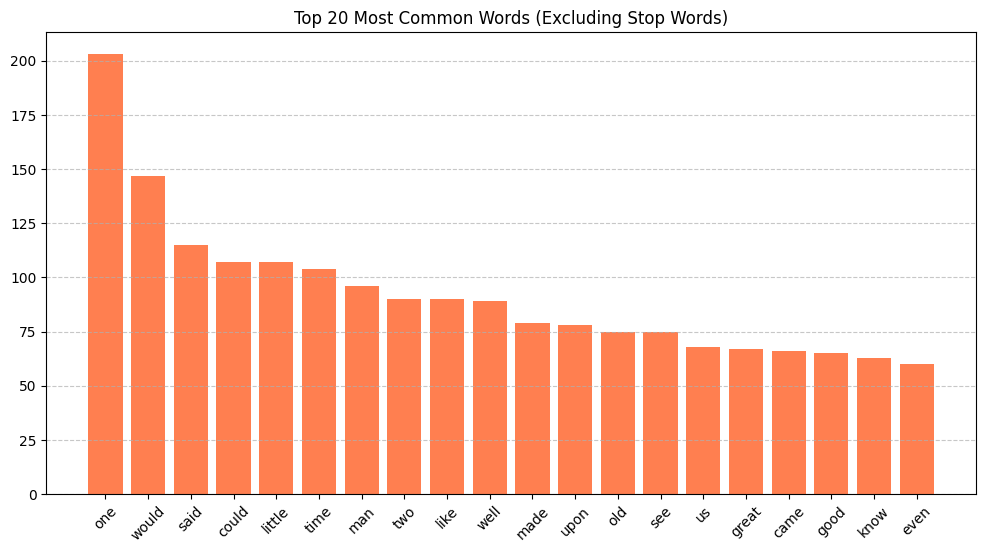

In [27]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

all_text = " ".join(data["whisper_text"].dropna().tolist()).lower()

# Tokenize and count words excluding stopwords
words = re.findall(r'\b\w+\b', all_text)
filtered_words = [word for word in words if word not in stop_words]
word_counts = Counter(filtered_words)

common_words = word_counts.most_common(20)
print("Top 20 common words (excluding stop words):", common_words)

plt.figure(figsize=(12, 6))
plt.bar(*zip(*common_words), color='coral')
plt.title("Top 20 Most Common Words (Excluding Stop Words)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Top 20 Bi-grams (excluding stop words): [(('could', 'see'), 10), (('two', 'three'), 8), (('one', 'another'), 7), (('old', 'man'), 7), (('every', 'man'), 6), (('lady', 'lady'), 6), (('would', 'go'), 6), (('mode', 'put'), 5), (('one', 'two'), 5), (('two', 'days'), 5), (('died', 'away'), 5), (('know', 'said'), 5), (('first', 'time'), 5), (('one', 'side'), 5), (('good', 'opinion'), 5), (('wandering', 'singer'), 5), (('emperor', 'daughter'), 5), (('young', 'man'), 5), (('green', 'box'), 5), (('mary', 'ann'), 5)]


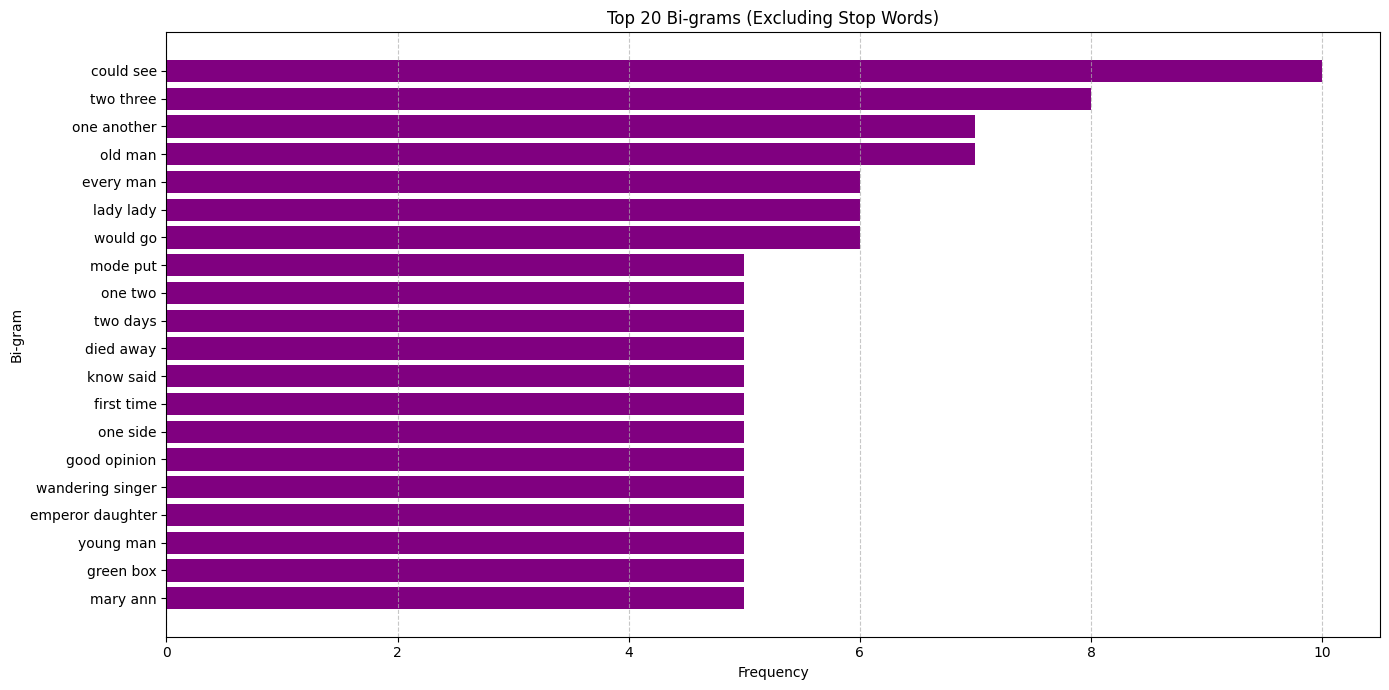

In [29]:
all_text = " ".join(data["whisper_text"].dropna().tolist()).lower()

# Tokenize and remove stop words
words = re.findall(r'\b\w+\b', all_text)
filtered_words = [word for word in words if word not in stop_words]

# Generate bi-grams
bigrams = list(ngrams(filtered_words, 2))

# Count bi-grams
bigram_counts = Counter(bigrams)

top_bigrams = bigram_counts.most_common(20)
print("Top 20 Bi-grams (excluding stop words):", top_bigrams)


plt.figure(figsize=(14, 7))
plt.barh([' '.join(bigram) for bigram, _ in top_bigrams], [count for _, count in top_bigrams], color='purple')
plt.title("Top 20 Bi-grams (Excluding Stop Words)")
plt.xlabel("Frequency")
plt.ylabel("Bi-gram")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [5]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r"[^a-z\s]", "", text)
    
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

In [6]:
# clean text
data['cleaned_text'] = data['text'].apply(clean_text)
data['cleaned_whisper_text'] = data['whisper_text'].apply(clean_text)

data.head()

,file,duration,text,token_length,whisper_text,cleaned_text,cleaned_whisper_text
0,Data/dev-clean/dev-clean/2412/153954/2412-153954-0019.flac,7.485,BUT BY AND BY THEY CAME TO MY WATCH WHICH I HAD HIDDEN AWAY IN THE INMOST POCKET THAT I HAD AND HAD FORGOTTEN WHEN THEY BEGAN THEIR SEARCH,30,"But by and by they came to my watch, which I had hidden away in the inn most pocket that I had and had forgotten when they began their search.",but by and by they came to my watch which i had hidden away in the inmost pocket that i had and had forgotten when they began their search,but by and by they came to my watch which i had hidden away in the inn most pocket that i had and had forgotten when they began their search
1,Data/dev-clean/dev-clean/2412/153954/2412-153954-0023.flac,2.650,THIS HAD SOME EFFECT IN CALMING HIM,7,This had some effect in calming him.,this had some effect in calming him,this had some effect in calming him
2,Data/dev-clean/dev-clean/2412/153954/2412-153954-0015.flac,11.390,SUFFICE IT THAT I FOUND MYSELF TAKEN BEFORE THE CHIEF MAGISTRATE AND BY HIS ORDERS WAS PLACED IN AN APARTMENT WITH TWO OTHER PEOPLE WHO WERE THE FIRST I HAD SEEN LOOKING ANYTHING BUT WELL AND HANDSOME,39,"Suffice it that I found myself taken before the chief magistrate, and by his orders was placed in an apartment with two other people. Who were the first I had seen looking anything but well in handsome.",suffice it that i found myself taken before the chief magistrate and by his orders was placed in an apartment with two other people who were the first i had seen looking anything but well and handsome,suffice it that i found myself taken before the chief magistrate and by his orders was placed in an apartment with two other people who were the first i had seen looking anything but well in handsome
3,Data/dev-clean/dev-clean/2412/153954/2412-153954-0003.flac,8.150,THE VINE GREW OUTSIDE MANY OF THE HOUSES AND THERE WERE SOME WITH SIGN BOARDS ON WHICH WAS PAINTED A BOTTLE AND A GLASS THAT MADE ME FEEL MUCH AT HOME,31,The vine grew outside many of the houses and there were some with signboards on which was painted a bottle and a glass that made me feel much at home,the vine grew outside many of the houses and there were some with sign boards on which was painted a bottle and a glass that made me feel much at home,the vine grew outside many of the houses and there were some with signboards on which was painted a bottle and a glass that made me feel much at home
4,Data/dev-clean/dev-clean/2412/153954/2412-153954-0002.flac,4.055,THE STREETS WERE NARROW AND UNPAVED BUT VERY FAIRLY CLEAN,12,The streets were narrow and unpaid but very fairly clean.,the streets were narrow and unpaved but very fairly clean,the streets were narrow and unpaid but very fairly clean


In [7]:
# measure accuracy
accuracy = data['cleaned_text'] == data['cleaned_whisper_text']
accuracy = accuracy.mean()
print(f"Exact match accuracy: {accuracy:.2%}")

Exact match accuracy: 46.54%


In [8]:
# measure accuracy using rouge score
rouge = Rouge()
rouge_scores = []

for i in range(len(data)):
    reference = data["cleaned_text"][i]
    candidate = data["cleaned_whisper_text"][i]

    if not reference.strip() or not candidate.strip():
        rouge_scores.append(0) # 0 score if either is empty
        continue

    scores = rouge.get_scores(candidate, reference)
    rouge_scores.append(scores[0]['rouge-l']['f']) # rouge-l for long text

data["rouge_score"] = rouge_scores

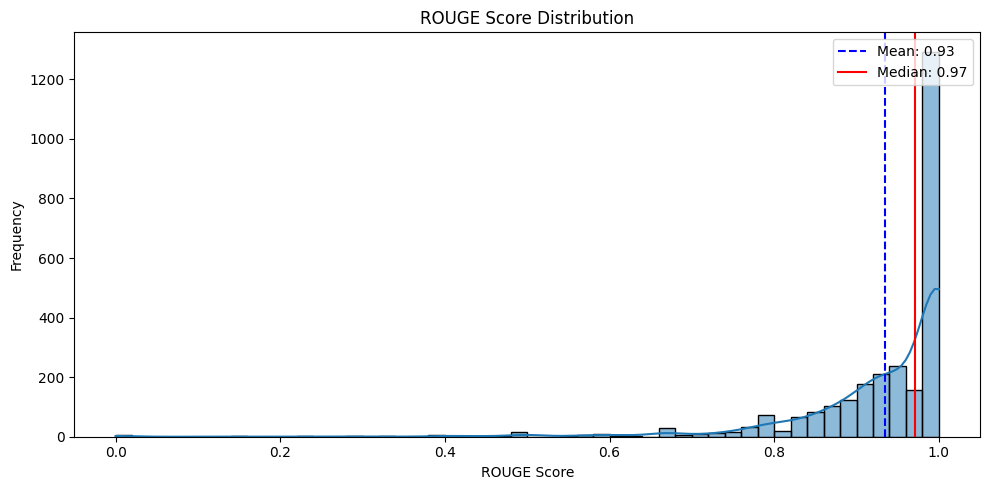

In [9]:
# histogram of rouge scores
plt.figure(figsize=(10, 5))
sns.histplot(data['rouge_score'], bins=50, kde=True)
plt.axvline(data['rouge_score'].mean(), color='blue', linestyle='--', label=f'Mean: {data["rouge_score"].mean():.2f}')
plt.axvline(data['rouge_score'].median(), color='red', linestyle='-', label=f'Median: {data["rouge_score"].median():.2f}')
plt.title('ROUGE Score Distribution')
plt.xlabel('ROUGE Score')
plt.ylabel('Frequency')
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

# 4. Extract Name Entities

In [66]:
! python -m spacy download en_core_web_trf

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 7.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [10]:
# combine audio text
data['group_key'] = data['file'].apply(lambda x: '/'.join(x.split('/')[-3:-1]))
data['file_num'] = data['file'].apply(lambda x: int(x.split('/')[-1].split('.')[0].split('-')[-1]))
df_sorted = data.sort_values(by=['group_key', 'file_num'])

combined_text = df_sorted.groupby('group_key')['cleaned_whisper_text'].apply(lambda texts: ' '.join(texts)).reset_index()
combined_text.columns = ['folder_path', 'combined_cleaned_whisper_text']
combined_text.head()

,folder_path,combined_cleaned_whisper_text
0,1272/128104,mr quilter is the apostle of the middle classes and we are glad to welcome his gospel nor is mr quilters manner less interesting than his matter he tells us that at this festive season of the year with christmas and roast beef looming before us similarly drawn from eating and its results occur most readily to the mind he has graved doubts whether sir frederick laytons work is really greek after all and can discover in it but little of rocky ithaca lynelles pictures are a sort of upgards and atom paintings and masons exquisite ittles are as national as a jingo poem mr birkett fosters landscapes smile at one much in the same way that mr carker used to flash his teeth and mr john collier gives his sitter a cheerful slap on the back before he says like a shampoo or a turkish bath next man it is obviously unnecessary for us to point out how luminous these criticisms are how delicate in expression on the general principles of art and mr krilter writes with equal lucidity painting he tells us is of a different quality to mathematics and finish in art is adding more factor as for etchings there are two kinds british and foreign he laments most bitterly the divorce that has been made between decorative art and what we usually call pictures mixed a customary appeal to the last judgment and reminds us that in the great days of art michelangelo was the furnishing upholsterer near the fire and the ornaments fred brought home from india on the mental board in fact he is quite severe on mr ruskin for not recognizing that a picture should denote the frailty of man and remarks with pleasing courtesy and felicitous grace that many phases were feeling only unfortunately his own work never does get good mr quilter has missed his chance for he has failed even to make himself the tupper of painting by harry quilter ma
1,1272/135031,because you were sleeping instead of conquering the lovely rose princess has become a fiddle without a bow while poroshaegi sits there accuing dove he has gone and gone for good answered polychrome who had managed to squeeze into the room beside the dragon and had witnessed the occurrences with much interest i have remained a prisoner only because i wish to be one and with this he stepped forward and burst the stout chains as easily as if they had been threads the little girl had been asleep but she heard the raps and opened the door the king is flooded disgrace and your friends are asking for you i begged ruggedo a long ago to send him away but he would not do so i also offered to help your brother to escape but he would not go he eats and sleeps very steadily replay the nooking i hope he doesnt work too hard since shaggy he doesnt work at all in fact there is nothing he can do in these dominions as well as our norms whose numbers are so great that it worries us to keep them all busy not exactly weve turned calico where is my brother now in quarered shaggy in the metal forest where is that the middle forest is in the great donde cavern the largest in all our dominions replied calico calago hesitated however if we look sharp we may be able to discover one of these secret ways oh no im quite sure he didnt thats funny remarked betsy thoughtfully i dont believe ann knew any magic or shed have worked it before i do not know confess to shaggy true agreed calico calico went to the big gong and pounded on it just as regular used to do but no one answered the summons having returned to the royal cavern calico first pounded the gong and then sat in the throne wearing reggados discarded ruby crown and holding in his hand the scepter which reggato had so often thrown at his head
2,1272/141231,a man said to the universe sir i exist sweatcovered brians body trickling into the titling class that was the only girl in the world the cut on his chest is still dripping blood the ache of his overstrained eyes even the soaring arena around him with the thousands of spectators retrieval

In [11]:
# use a transformer-based NER model
nlp = spacy.load("en_core_web_trf")

def extract_named_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

In [12]:
combined_text['named_entities'] = combined_text['combined_cleaned_whisper_text'].apply(extract_named_entities)

In [13]:
combined_text.head(5)

,folder_path,combined_cleaned_whisper_text,named_entities
0,1272/128104,mr quilter is the apostle of the middle classes and we are glad to welcome his gospel nor is mr quilters manner less interesting than his matter he tells us that at this festive season of the year with christmas and roast beef looming before us similarly drawn from eating and its results occur most readily to the mind he has graved doubts whether sir frederick laytons work is really greek after all and can discover in it but little of rocky ithaca lynelles pictures are a sort of upgards and atom paintings and masons exquisite ittles are as national as a jingo poem mr birkett fosters landscapes smile at one much in the same way that mr carker used to flash his teeth and mr john collier gives his sitter a cheerful slap on the back before he says like a shampoo or a turkish bath next man it is obviously unnecessary for us to point out how luminous these criticisms are how delicate in expression on the general principles of art and mr krilter writes with equal lucidity painting he tells us is of a different quality to mathematics and finish in art is adding more factor as for etchings there are two kinds british and foreign he laments most bitterly the divorce that has been made between decorative art and what we usually call pictures mixed a customary appeal to the last judgment and reminds us that in the great days of art michelangelo was the furnishing upholsterer near the fire and the ornaments fred brought home from india on the mental board in fact he is quite severe on mr ruskin for not recognizing that a picture should denote the frailty of man and remarks with pleasing courtesy and felicitous grace that many phases were feeling only unfortunately his own work never does get good mr quilter has missed his chance for he has failed even to make himself the tupper of painting by harry quilter ma,"[(quilter, PERSON), (quilters, PERSON), (this festive season of the year, DATE), (christmas, DATE), (frederick laytons, PERSON), (greek, NORP), (upgards, PERSON), (atom, PERSON), (masons, PERSON), (birkett, PERSON), (carker, PERSON), (john collier, PERSON), (turkish, NORP), (krilter, PERSON), (two, CARDINAL), (british, NORP), (the great days, DATE), (michelangelo, PERSON), (fred, PERSON), (india, GPE), (the mental board, ORG), (ruskin, PERSON), (quilter, PERSON), (harry quilter ma, PERSON)]"
1,1272/135031,because you were sleeping instead of conquering the lovely rose princess has become a fiddle without a bow while poroshaegi sits there accuing dove he has gone and gone for good answered polychrome who had managed to squeeze into the room beside the dragon and had witnessed the occurrences with much interest i have remained a prisoner only because i wish to be one and with this he stepped forward and burst the stout chains as easily as if they had been threads the little girl had been asleep but she heard the raps and opened the door the king is flooded disgrace and your friends are asking for you i begged ruggedo a long ago to send him away but he would not do so i also offered to help your brother to escape but he would not go he eats and sleeps very steadily replay the nooking i hope he doesnt work too hard since shaggy he doesnt work at all in fact there is nothing he can do in these dominions as well as our norms whose numbers are so great that it worries us to keep them all busy not exactly weve turned calico where is my brother now in quarered shaggy in the metal forest where is that the middle forest is in the great donde cavern the largest in all our dominions replied calico calago hesitated however if we look sharp we may be able to discover one of these secret ways oh no im quite sure he didnt thats funny remarked betsy thoughtfully i dont believe ann knew any magic or shed have worked it before i do not know confess to shaggy true agreed calico calico went to the big gong and pounded on it just as regular used to do but no one answered the summons ha

In [ ]:
# save csv
combined_text.to_csv("data/combined_text.csv", index=False)

# 5. Summarize Text

## 5.1 Original T5

In [3]:
summarizer =  pipeline("summarization", model="t5-small",tokenizer="t5-small")

Device set to use cuda:0


In [4]:
def summarize_text(text, min_chars=500, max_len=150, min_len=40):
    if len(text.strip()) < min_chars:
        return ""
    try:
        prompt = "summarize: " + text.strip()
        summary = summarizer(prompt, max_length=max_len, min_length=min_len, do_sample=False)
        return summary[0]['summary_text']
    except Exception as e:
        print(f"Error: {e}")
        return ""

In [5]:
def summarize_long(text):
    return summarize_text(text, max_len=400, min_len=150)

def summarize_short(text):
    return summarize_text(text,max_len=150, min_len=100)

def summarize_tiny(text):
    return summarize_text(text, max_len=40, min_len=15)

In [8]:
combined_text['summary_long'] = combined_text['combined_cleaned_whisper_text'].apply(summarize_long)
combined_text['summary_short'] = combined_text['combined_cleaned_whisper_text'].apply(summarize_short)
combined_text['summary_tiny'] = combined_text['combined_cleaned_whisper_text'].apply(summarize_tiny)

Token indices sequence length is longer than the specified maximum sequence length for this model (597 > 512). Running this sequence through the model will result in indexing errors
Your max_length is set to 400, but your input_length is only 398. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=199)
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Your max_length is set to 400, but your input_length is only 342. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=171)
Your max_length is set to 400, but your input_length is only 198. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manua

In [ ]:
combined_text.to_csv("data/original_t5_summary.csv", index = False)

## 5.2 Fine-Tuned T5

In [59]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")

adapter_sizes = ["tiny", "short", "long"]
summarizers = {}

for size in adapter_sizes:
    adapter_path = os.path.join("LoRA_Weights", f"lora_adapters_{size}")
    
    # load fresh model for each size
    base_model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
    model_with_lora = PeftModel.from_pretrained(base_model, adapter_path)

    summarizer = pipeline(
        "summarization",
        model=model_with_lora,
        tokenizer=tokenizer
    )

    summarizers[size] = summarizer

Device set to use mps:0
The model 'PeftModelForSeq2SeqLM' is not supported for summarization. Supported models are ['BartForConditionalGeneration', 'BigBirdPegasusForConditionalGeneration', 'BlenderbotForConditionalGeneration', 'BlenderbotSmallForConditionalGeneration', 'EncoderDecoderModel', 'FSMTForConditionalGeneration', 'GPTSanJapaneseForConditionalGeneration', 'LEDForConditionalGeneration', 'LongT5ForConditionalGeneration', 'M2M100ForConditionalGeneration', 'MarianMTModel', 'MBartForConditionalGeneration', 'MT5ForConditionalGeneration', 'MvpForConditionalGeneration', 'NllbMoeForConditionalGeneration', 'PegasusForConditionalGeneration', 'PegasusXForConditionalGeneration', 'PLBartForConditionalGeneration', 'ProphetNetForConditionalGeneration', 'Qwen2AudioForConditionalGeneration', 'SeamlessM4TForTextToText', 'SeamlessM4Tv2ForTextToText', 'SwitchTransformersForConditionalGeneration', 'T5ForConditionalGeneration', 'UMT5ForConditionalGeneration', 'XLMProphetNetForConditionalGeneration'

In [77]:
# Control length of summaries per style
length_map = {
    "tiny": (10, 40),
    "short": (100, 150),
    "long": (150, 400)
}

def clean_summary(text, add_paragraphs=False):
    if not text:
        return ""
    
    # ensure proper ending punctuation
    if not text.endswith(('.', '!', '?')):
        # find the last sentence ending or comma
        # since a lot of the tiny paragraphs ends at comma, so we cleaned it up more here
        last_period = max(text.rfind('.'), text.rfind('!'), text.rfind('?'))
        last_comma = text.rfind(',')
        
        if last_period > 0 and last_period > last_comma:
            # if it is a proper sentence, then just go with it
            text = text[:last_period+1]
        elif last_comma > 0:
            # if we have comma but no proper sentence ending, replace the comma with period
            # seen lots of case are like this for tiny
            text = text[:last_comma] + "."
        else:
            # if no ending found, add period
            text = text.rstrip() + "."
    
    # add pargraph breaks for long summary
    # since the data used for fine-tuning model is mostly 3 sentences for each paragraph, so we break the paragraph for every 3 sentences.
    if add_paragraphs:
        abbreviations = [r"Mr\.", r"Mrs\.", r"Ms\.", r"Dr\."]
        # protect abbreviations by replacing their “.” with a placeholder
        # clean out the dot on the abbreviation
        protected = text
        for abbr in abbreviations:
            protected = re.sub(abbr, lambda m: m.group(0).replace(".", "<DOT>"),protected)

        # split based on the sentence punctuation
        parts = re.split(r'(?<=[.!?])\s+', protected)

        # restore the '.' in the abbreviation
        sentences = [p.replace("<DOT>", ".") for p in parts]
        
        # only add paragraphs if we have enough sentences
        if len(sentences) >= 4:  # need at least 4 sentences to have more than one paragraph
            paragraphs = []
            current_para = []
            
            for i, sentence in enumerate(sentences):
                current_para.append(sentence)
                
                # create a paragraph break after every 3rd sentence
                if (i + 1) % 3 == 0 and i < len(sentences) - 1:
                    paragraphs.append(' '.join(current_para))
                    current_para = []
            
            # add any remaining sentences as the final paragraph
            if current_para:
                paragraphs.append(' '.join(current_para))
            
            text = '\n\n'.join(paragraphs)
    
    return text

In [78]:
def summarize_finetuned(text, length_type="short"):
    if length_type not in length_map:
        raise ValueError(f"Length type '{length_type}' not supported. Use: {list(length_map.keys())}")

    min_len, max_len = length_map[length_type]

    try:
        # use the correct summarizer based on length_type
        summarizer = summarizers[length_type]
        
        prompt = ("summarize: " + text.strip())[:1024]
        result = summarizer(prompt, min_length = min_len, max_length=max_len, do_sample=False)
        summary = result[0]["summary_text"]
        
        # apply cleaning and formatting based on length type
        add_paragraphs = length_type == "long"  # Only add paragraphs for long summaries
        summary = clean_summary(summary, add_paragraphs)
        
        return summary.strip()
    except Exception as e:
        print(f"Error: {e}")
        return ""

In [83]:
text = combined_text['combined_cleaned_whisper_text'].loc[0]

print(f"Tiny Summary:\n{summarize_finetuned(text, 'tiny')}")
print(f"Short Summary:\n{summarize_finetuned(text, 'short')}")
print(f"Long Summary:\n{summarize_finetuned(text, 'long')}")

Tiny Summary:
Mr. Quilter is the apostle of the middle classes, and he tells us that at this festive season, with Christmas and roast beef looming before us similarly drawn from eating.
Short Summary:
Mr. Quilter is the apostle of the middle classes and we welcome his gospel. He has doubts whether Sir Fred Layton's work is really greek after all and can discover in it, but little of rocky ithaca lynelles pictures are a sort of upgards and atom paintings, and masons exquisite ittles are as national as a jingo poem. Mr. Birkett fosters landscapes smile at one much in the same way as Mr. Carker used to flash his teeth, and Mr. Clark gives his sitter a cheerful slap on the back.
Long Summary:
Mr. Quilter, an advocate for the middle class, is the apostle of the middle classes and is glad to welcome his gospel. He tells us that at this festive season of the year, roast beef looms before us, drawing from eating and its results most readily to the mind. He has doubts whether Sir Frederick Layt

In [84]:
text = combined_text['combined_cleaned_whisper_text'].loc[1]

print(f"Tiny Summary:\n{summarize_finetuned(text, 'tiny')}")
print(f"Short Summary:\n{summarize_finetuned(text, 'short')}")
print(f"Long Summary:\n{summarize_finetuned(text, 'long')}")

Tiny Summary:
The king is flooded with disgrace, and his friends ask for him to send him away, but he doesn't work too hard, especially since shaggy.
Short Summary:
Poroshaegi sits in the room beside the dragon and witnessed the occurrences with interest. The little girl had been asleep, but she heard the raps and opened the door. The king is flooded with disgrace and friends are asking for him to send him away, but he would not go, and eats and sleeps steadily, despite shaggy's lack of work in these dominions and our norms, which worries us to keep them busy.
Long Summary:
Polychrome, an advocate for the middle class, argues that the lovely rose princess has become a fiddle without a bow, and Poroshaegi sits there, accuing Dove, who has gone and gone for good, answered Polychrom, who had managed to squeeze into the room beside the dragon. The little girl had been asleep, but she heard the raps and opened the door, and the king is flooded disgrace, and her friends are asking for you. T

In [88]:
# use tqdm to see the progress bar of the summarization
tqdm.pandas()

# create a new variable for the summarization
text_with_summary = combined_text.copy()

# do for loop for every style
for style in ["tiny", "short", "long"]:
    text_with_summary[f"summary_{style}"] = (text_with_summary["combined_cleaned_whisper_text"]
                                             .progress_apply(lambda txt: summarize_finetuned(txt, length_type=style)))

  0%|          | 0/97 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 97/97 [13:57<00:00,  8.64s/it]


In [89]:
text_with_summary.head()

,folder_path,combined_cleaned_whisper_text,named_entities,summary_tiny,summary_short,summary_long
0,1272/128104,mr quilter is the apostle of the middle classes and we are glad to welcome his gospel nor is mr quilters manner less interesting than his matter he tells us that at this festive season of the year with christmas and roast beef looming before us similarly drawn from eating and its results occur most readily to the mind he has graved doubts whether sir frederick laytons work is really greek after all and can discover in it but little of rocky ithaca lynelles pictures are a sort of upgards and atom paintings and masons exquisite ittles are as national as a jingo poem mr birkett fosters landscapes smile at one much in the same way that mr carker used to flash his teeth and mr john collier gives his sitter a cheerful slap on the back before he says like a shampoo or a turkish bath next man it is obviously unnecessary for us to point out how luminous these criticisms are how delicate in expression on the general principles of art and mr krilter writes with equal lucidity painting he tells us is of a different quality to mathematics and finish in art is adding more factor as for etchings there are two kinds british and foreign he laments most bitterly the divorce that has been made between decorative art and what we usually call pictures mixed a customary appeal to the last judgment and reminds us that in the great days of art michelangelo was the furnishing upholsterer near the fire and the ornaments fred brought home from india on the mental board in fact he is quite severe on mr ruskin for not recognizing that a picture should denote the frailty of man and remarks with pleasing courtesy and felicitous grace that many phases were feeling only unfortunately his own work never does get good mr quilter has missed his chance for he has failed even to make himself the tupper of painting by harry quilter ma,"[(quilter, PERSON), (quilters, PERSON), (this festive season of the year, DATE), (christmas, DATE), (frederick laytons, PERSON), (greek, NORP), (upgards, PERSON), (atom, PERSON), (masons, PERSON), (birkett, PERSON), (carker, PERSON), (john collier, PERSON), (turkish, NORP), (krilter, PERSON), (two, CARDINAL), (british, NORP), (the great days, DATE), (michelangelo, PERSON), (fred, PERSON), (india, GPE), (the mental board, ORG), (ruskin, PERSON), (quilter, PERSON), (harry quilter ma, PERSON)]","Mr. Quilter is the apostle of the middle classes, and he tells us that at this festive season, with Christmas and roast beef looming before us similarly drawn from eating.","Mr. Quilter is the apostle of the middle classes and we welcome his gospel. He has doubts whether Sir Fred Layton's work is really greek after all and can discover in it, but little of rocky ithaca lynelles pictures are a sort of upgards and atom paintings, and masons exquisite ittles are as national as a jingo poem. Mr. Birkett fosters landscapes smile at one much in the same way as Mr. Carker used to flash his teeth, and Mr. Clark gives his sitter a cheerful slap on the back.","Mr. Quilter, an advocate for the middle class, is the apostle of the middle classes and is glad to welcome his gospel. He tells us that at this festive season of the year, roast beef looms before us, drawing from eating and its results most readily to the mind. He has doubts whether Sir Frederick Layton's work is really greek after all, and can discover little of rocky Ithaca.\n\nLynelles pictures are a sort of upgards and atom paintings, and Masons, exquisite ittles are as national as a Jingo poem. Mr. Birkett fosters landscapes smile at one much in the same way as Mr. Carker used to flash his teeth, and Mr. John Collier gives his sitter a cheerful slap on the back before saying like a shampoo or turkish bath. He asks that he asks us about how luminous these criticisms are on the general principles of art and Mr. Krilter writes with equal lucidity painting as he says it is unnecessary for

In [ ]:
text_with_summary.to_csv("data/fine_turned_t5_summary.csv", index = False)

## 5.3 LLM-Based Agentic Summarizer with In-Context Learning

In [7]:
# get hugging face token and log in
load_dotenv()
hf_token = os.getenv("HUGGINGFACE_TOKEN")
login(hf_token)

In [ ]:
# read combined text csv
combined_text = pd.read_csv("data/combined_text.csv")

In [9]:
'''
# load llama 4 with 4-bit quantization
processor = AutoProcessor.from_pretrained("meta-llama/Llama-4-Scout-17B-16E-Instruct")
model = AutoModelForImageTextToText.from_pretrained(
    "meta-llama/Llama-4-Scout-17B-16E-Instruct",
    load_in_4bit=True,
    device_map="auto"
)
'''

'\n# load llama 4 with 4-bit quantization\nprocessor = AutoProcessor.from_pretrained("meta-llama/Llama-4-Scout-17B-16E-Instruct")\nmodel = AutoModelForImageTextToText.from_pretrained(\n    "meta-llama/Llama-4-Scout-17B-16E-Instruct",\n    load_in_4bit=True,\n    device_map="auto"\n)\n'

In [10]:
# load llama 3
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, 
                                             torch_dtype=torch.float16, 
                                             device_map="auto")

Loading checkpoint shards: 100%|██████████| 4/4 [00:08<00:00,  2.07s/it]


In [36]:
def llm(prompt, max_new_tokens=512, temperature=0.4):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if prompt in decoded:
        return decoded[len(prompt):].strip()
    return decoded.strip()

In [37]:
# summarizer prompt
def get_long_summary_prompt(text):
    return f"""<|system|>
You are a helpful AI assistant specialized in text summarization. 
<|user|>
I need you to summarize the following text into three to five paragraphs (150–400 words). Return only the summary. Do not include any introductory or concluding sentences, explanations, or conversational statements. Your output must be the summary only.

Example text: long ago they lived in merchant who had three daughters every year at a certain day of a certain month he went away to a distant city to collect money when an account how do you know astor father i am older and wiser than you are and i know that there are many evils which might come upon you when it was evening he led his band into a nearby street and in his disguise approached the merchants house he knocked at the door have pity upon a poor unfortunate one he called out let me enter i pray you to pass the night under your roof its surely a terrible storm outside so the merchants eldest daughter as the wind rattled the tiles of the roof and the rain beat in torrents against the doors and windows he is old as well as poor she said if we decide to show mercy to this poor beggar it is not for you to oppose it but we should not forget our promise to our father cried the youngest daughter however in spite of all she could say the elder sisters opened the door and admitted the bigger it is a fearful night to send away a bigger said the eldest sister while they were eating while they were talking the beggar had taken the apples which the girls were to eat for dessert and had sprinkled a sleeping powder over them the two eldest ate their apples but the youngest could not eat that night she threw the apple away she did not stir and he knew that the sleeping powder had thoroughly done its work then she hurt him go down the stairway and unbolt the heavy doors which led into the store it was the youngest one who deceived me cried the robert chieftain perhaps we can outlet her yet cry another the merchants daughter at first did not answer but as he kept on calling to her she finally asked him what it was that he wanted i promise you i will do you no harm you shall not come into my fathers house pass the charm out to me then said the robber when she returned his hand was sticking through the hole in the door the cries and curses of the robbers filled the air they tried and vane to break down the great doors all my worries about you were foolish

<|assistant|>
A merchant with three daughters traveled each year to a distant city to collect money. One evening during a terrible storm, while the merchant was away, a beggar came to their house asking for shelter. The eldest daughters, moved by his plea, insisted on letting him in despite their youngest sister’s warning that they should honor their father’s instructions.

During dinner, the beggar secretly sprinkled sleeping powder on the apples meant for dessert. The two elder sisters ate the apples and fell asleep, but the youngest, suspicious, did not eat hers. Awake and alert, she heard the beggar—revealed to be a robber—go downstairs to unbolt the doors leading to the merchant’s store. Realizing her plan was foiled, the robber chief became furious, and his gang tried in vain to break into the house.

Despite their efforts and curses, the youngest daughter’s caution and bravery protected the household from harm. Her wisdom proved greater than her sisters’ kindness, showing that mercy should be tempered with vigilance, especially when danger is near.

<|user|>
Now please summarize this text into two to four paragraphs:

{text}

<|assistant|>
"""

def get_short_summary_prompt(text):
    return f"""<|system|>
You are a helpful AI assistant specialized in text summarization.
<|user|>
I need you to summarize the following text into a single concise paragraph (100–150 words). Return only the summary. Do not include any introductory or concluding sentences, explanations, or conversational statements. Your output must be the summary only.

Example text: long ago they lived in merchant who had three daughters every year at a certain day of a certain month he went away to a distant city to collect money when an account how do you know astor father i am older and wiser than you are and i know that there are many evils which might come upon you when it was evening he led his band into a nearby street and in his disguise approached the merchants house he knocked at the door have pity upon a poor unfortunate one he called out let me enter i pray you to pass the night under your roof its surely a terrible storm outside so the merchants eldest daughter as the wind rattled the tiles of the roof and the rain beat in torrents against the doors and windows he is old as well as poor she said if we decide to show mercy to this poor beggar it is not for you to oppose it but we should not forget our promise to our father cried the youngest daughter however in spite of all she could say the elder sisters opened the door and admitted the bigger it is a fearful night to send away a bigger said the eldest sister while they were eating while they were talking the beggar had taken the apples which the girls were to eat for dessert and had sprinkled a sleeping powder over them the two eldest ate their apples but the youngest could not eat that night she threw the apple away she did not stir and he knew that the sleeping powder had thoroughly done its work then she hurt him go down the stairway and unbolt the heavy doors which led into the store it was the youngest one who deceived me cried the robert chieftain perhaps we can outlet her yet cry another the merchants daughter at first did not answer but as he kept on calling to her she finally asked him what it was that he wanted i promise you i will do you no harm you shall not come into my fathers house pass the charm out to me then said the robber when she returned his hand was sticking through the hole in the door the cries and curses of the robbers filled the air they tried and vane to break down the great doors all my worries about you were foolish

<|assistant|>
While their merchant father was away, three sisters sheltered a beggar during a fierce storm, despite the youngest’s warning to keep their promise to their father. The beggar, actually a robber in disguise, drugged the elder sisters with sleeping powder, but the cautious youngest sister avoided the trap. Staying awake, she overheard the robber’s plan to break into the house and foiled his attempt, saving her family through her vigilance and quick thinking.

<|user|>
Now please summarize this text into a single concise paragraph:

{text}

<|assistant|>
"""

def get_tiny_summary_prompt(text):
    return f"""<|system|>
You are a helpful AI assistant specialized in text summarization.
<|user|>
I need you to summarize the following text into a single sentence (15–40 words). Return only the summary. Do not include any introductory or concluding sentences, explanations, or conversational statements. Your output must be the summary only.

Example text: long ago they lived in merchant who had three daughters every year at a certain day of a certain month he went away to a distant city to collect money when an account how do you know astor father i am older and wiser than you are and i know that there are many evils which might come upon you when it was evening he led his band into a nearby street and in his disguise approached the merchants house he knocked at the door have pity upon a poor unfortunate one he called out let me enter i pray you to pass the night under your roof its surely a terrible storm outside so the merchants eldest daughter as the wind rattled the tiles of the roof and the rain beat in torrents against the doors and windows he is old as well as poor she said if we decide to show mercy to this poor beggar it is not for you to oppose it but we should not forget our promise to our father cried the youngest daughter however in spite of all she could say the elder sisters opened the door and admitted the bigger it is a fearful night to send away a bigger said the eldest sister while they were eating while they were talking the beggar had taken the apples which the girls were to eat for dessert and had sprinkled a sleeping powder over them the two eldest ate their apples but the youngest could not eat that night she threw the apple away she did not stir and he knew that the sleeping powder had thoroughly done its work then she hurt him go down the stairway and unbolt the heavy doors which led into the store it was the youngest one who deceived me cried the robert chieftain perhaps we can outlet her yet cry another the merchants daughter at first did not answer but as he kept on calling to her she finally asked him what it was that he wanted i promise you i will do you no harm you shall not come into my fathers house pass the charm out to me then said the robber when she returned his hand was sticking through the hole in the door the cries and curses of the robbers filled the air they tried and vane to break down the great doors all my worries about you were foolish

<|assistant|>
When a beggar-turned-robber tricks two sisters into eating sleeping powder, the youngest sister’s caution thwarts his plan and protects her family.

<|user|>
Now please summarize this text into a single sentence:

{text}

<|assistant|>
"""

In [38]:
# evaluator prompt
def build_evaluator_prompt(original_text, summary, summary_type):
    return f"""<|system|>
You are a critical reviewer of summaries. You read an original text, a summary, and decide if the summary is good or not, following the provided examples. Output your decision and feedback using the format shown in the examples.

<|user|>
Example 1:
Original text:
The cat sat on the mat. The dog barked at the mailman.

Summary:
A cat sat on a mat while a dog barked at a mailman.

Evaluation:
- Result: Pass
- Feedback: The summary covers all key details accurately and concisely.

Example 2:
Original text:
Alice goes to Wonderland and meets many strange creatures.

Summary:
Alice meets some people.

Evaluation:
- Result: Fail
- Feedback: The summary is too vague and omits many important plot points.

Now, evaluate the following summary:

Original text:
{original_text}

Summary:
{summary}

Return your response in this format:
- Result: <Pass or Fail>
- Feedback: <Your feedback>
<|assistant|>
"""

In [39]:
# regenerator prompt
def get_regenerator_prompt(text, last_summary, feedback, summary_type):
    if summary_type == "long":
        prompt = f"""<|system|>
You are a helpful AI assistant specialized in text summarization.
<|user|>
Please summarize the original text into three to five paragraphs (150–400 words), addressing the evaluator's feedback of the last summary below. Return only the summary. Do not include any introductory or concluding sentences, explanations, or conversational statements. Your output must be the summary only.

Original text:
{text}

Last summary:
{last_summary}

Evaluator feedback of last summary:
{feedback}
<|assistant|>
"""
    elif summary_type == "short":
        prompt = f"""<|system|>
You are a helpful AI assistant specialized in text summarization.
<|user|>
Please summarize the original text in a single paragraph (100–150 words), addressing the evaluator's feedback of the last summary below. Return only the summary. Do not include any introductory or concluding sentences, explanations, or conversational statements. Your output must be the summary only.

Original text:
{text}

Last summary:
{last_summary}

Evaluator feedback of last summary:
{feedback}
<|assistant|>
"""
    elif summary_type == "tiny":
        prompt = f"""<|system|>
You are a helpful AI assistant specialized in text summarization.
<|user|>
Please summarize the original text in a single sentence (15–40 words), addressing the evaluator's feedback of the last summary below. Return only the summary. Do not include any introductory or concluding sentences, explanations, or conversational statements. Your output must be the summary only.

Original text:
{text}

Last summary:
{last_summary}

Evaluator feedback of last summary:
{feedback}
<|assistant|>
"""
    else:
        raise ValueError("Invalid summary_type.")
    return prompt

In [40]:
# define agents
def summarizer_node(state):
    summary_type = state["summary_type"]
    text = state["text"]
    if summary_type == "long":
        prompt = get_long_summary_prompt(text)
    elif summary_type == "short":
        prompt = get_short_summary_prompt(text)
    elif summary_type == "tiny":
        prompt = get_tiny_summary_prompt(text)
    else:
        raise ValueError("Invalid summary_type.")
    state["summary"] = llm(prompt)
    return state

def evaluator_node(state):
    eval_prompt = build_evaluator_prompt(state["text"], state["summary"], state["summary_type"])
    eval_result = llm(eval_prompt)
    state["eval_result"] = eval_result
    state["pass"] = "pass" in eval_result.lower()
    return state

def regenerator_node(state):
    state["attempts"] = state.get("attempts", 0) + 1
    feedback = state["eval_result"]
    summary_type = state["summary_type"]
    text = state["text"]
    last_summary = state["summary"]

    prompt = get_regenerator_prompt(text, last_summary, feedback, summary_type)
    state["summary"] = llm(prompt)
    return state

def router(state):
    if state.get("pass", False) or state["attempts"] >= 3:
        return END
    else:
        print('Finished trial ' + str(state["attempts"]+1))
        return "regenerator"

In [41]:
# create graph
class SummaryState(TypedDict, total=False):
    text: str
    summary_type: str
    summary: str
    eval_result: str
    pass_: bool
    attempts: int

graph = StateGraph(state_schema=SummaryState)
graph.add_node("summarizer", summarizer_node)
graph.add_node("evaluator", evaluator_node)
graph.add_node("regenerator", regenerator_node)
graph.add_edge("summarizer", "evaluator")
graph.add_conditional_edges("evaluator", router)
graph.add_edge("regenerator", "evaluator")
graph.set_entry_point("summarizer")
langgraph_pipeline = graph.compile()

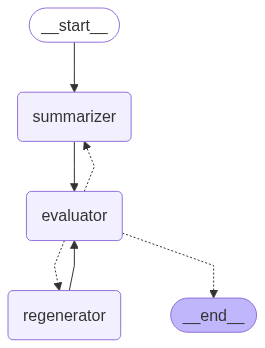

In [42]:
# visualize graph
display(
    Image(
        langgraph_pipeline.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [43]:
# clean generated text
def clean_summary(text):
    lines = text.strip().split('\n')
    cleaned_lines = []
    stop_markers = re.compile(r'^\s*(<\|system\|>|<\|user\|>|<\|assistant\|>|system|user|assistant|Generated text)', re.IGNORECASE)
    skip_markers = re.compile(r'^\s*(here|improved|revised|rewritten|summary)[^:]*:', re.IGNORECASE)

    for line in lines:
        if stop_markers.match(line):
            break  # stop collecting lines
        if skip_markers.match(line):
            continue  # skip this line
        stripped = line.strip()
        if stripped:
            cleaned_lines.append(stripped)
    return '\n\n'.join(cleaned_lines)

In [44]:
def get_summary(text, summary_type):
    state = {
        "text": text,
        "summary_type": summary_type,
        "attempts": 0
    }
    result = langgraph_pipeline.invoke(state)
    if not result.get("pass", False) and result["attempts"] >= 3:
        return "Can't generate summary. Please try again."
    else:
        #print(result['eval_result'])
        return clean_summary(result["summary"])

In [27]:
# test one example
print(get_summary(combined_text['combined_cleaned_whisper_text'].loc[20], "tiny"))

Peter, struggling with financial woes and personal troubles, seeks advice from Mr. Shimera, while elsewhere, Pavel and his companions flee their village, pursued by a dark past and haunted by the sound of a distant monastery bell.


In [ ]:
combined_text["summary_long"] = ""
combined_text["summary_short"] = ""
combined_text["summary_tiny"] = ""

for idx, row in tqdm(combined_text.iterrows(), total=len(combined_text)):
    text = row["combined_cleaned_whisper_text"]
    combined_text.at[idx, "summary_long"]  = get_summary(text, "long")
    combined_text.at[idx, "summary_short"] = get_summary(text, "short")
    combined_text.at[idx, "summary_tiny"]  = get_summary(text, "tiny")

  3%|▎         | 3/97 [02:01<1:02:57, 40.18s/it]

Finished trial 1
Finished trial 2


  4%|▍         | 4/97 [03:23<1:27:51, 56.68s/it]

Finished trial 1


  6%|▌         | 6/97 [05:02<1:17:55, 51.38s/it]

Finished trial 1


  7%|▋         | 7/97 [06:27<1:33:40, 62.45s/it]

Finished trial 1
Finished trial 1


  8%|▊         | 8/97 [07:56<1:45:20, 71.02s/it]

Finished trial 1


 11%|█▏        | 11/97 [10:29<1:19:29, 55.46s/it]

Finished trial 1
Finished trial 1
Finished trial 2


 15%|█▌        | 15/97 [14:19<1:10:39, 51.70s/it]

Finished trial 1


 21%|██        | 20/97 [17:43<52:01, 40.54s/it]  

Finished trial 1
Finished trial 2
Finished trial 3


 22%|██▏       | 21/97 [19:35<1:18:22, 61.87s/it]

Finished trial 1
Finished trial 1


 33%|███▎      | 32/97 [29:23<57:34, 53.15s/it]  

Finished trial 1
Finished trial 1


 46%|████▋     | 45/97 [41:00<49:49, 57.49s/it]  

Finished trial 1
Finished trial 1


 51%|█████     | 49/97 [45:10<44:45, 55.95s/it]

Finished trial 1
Finished trial 2
Finished trial 3


 61%|██████    | 59/97 [54:12<32:32, 51.38s/it]

Finished trial 1


 64%|██████▍   | 62/97 [56:57<30:43, 52.68s/it]

Finished trial 1
Finished trial 2
Finished trial 1


 73%|███████▎  | 71/97 [1:05:12<20:55, 48.28s/it]

Finished trial 1


 75%|███████▌  | 73/97 [1:06:55<19:27, 48.66s/it]

In [50]:
# check rows without successful generation in 3 trials
summary_cols = ['summary_long', 'summary_short', 'summary_tiny']
invalid_msg = "Can't generate summary. Please try again."

llama3_fail = combined_text[(combined_text[summary_cols] == invalid_msg).any(axis=1)]
llama3_fail

,folder_path,combined_cleaned_whisper_text,named_entities,summary_long,summary_short,summary_tiny
49,3853/163249,her meeting with ledi was indescribably tender...,"[('ledi', 'PERSON'), ('christi', 'PERSON'), ('...",Can't generate summary. Please try again.,"Christie and David, now a married couple, prep...",As Christie and David prepare for their weddin...
92,84/121550,but with full ravishment the hours of prime si...,"[('prosupina', 'PERSON'), ('venus', 'PERSON'),...",Can't generate summary. Please try again.,"As I walked with the lady, our path turned eas...",As Dante and Virgil journey through the afterl...


In [51]:
# manully regenerate summary for these rows
for idx, row in llama3_fail.iterrows():
    text = row['combined_cleaned_whisper_text']
    combined_text.at[idx, "summary_long"]  = get_summary(text, "long")
    combined_text.at[idx, "summary_short"] = get_summary(text, "short")
    combined_text.at[idx, "summary_tiny"]  = get_summary(text, "tiny")


Finished trial 1
Finished trial 2


In [52]:
# check rows without successful generation in 3 trials again
llama3_fail = combined_text[(combined_text[summary_cols] == invalid_msg).any(axis=1)]
llama3_fail

,folder_path,combined_cleaned_whisper_text,named_entities,summary_long,summary_short,summary_tiny


In [ ]:
combined_text.to_csv("data/llama_agent_summary.csv", index = False)

# 6. Summary Evaluation and Model Comparison

## 6.1 LLM-as-a-judge

In [2]:
original_t5 = pd.read_csv('data/original_t5_summary.csv')
ft_t5 = pd.read_csv("data/fine_turned_t5_summary.csv")
llama3 = pd.read_csv("data/llama_agent_summary.csv")

In [56]:
original_t5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   folder_path                    97 non-null     object
 1   combined_cleaned_whisper_text  97 non-null     object
 2   named_entities                 97 non-null     object
 3   summary_long                   97 non-null     object
 4   summary_short                  97 non-null     object
 5   summary_tiny                   97 non-null     object
dtypes: object(6)
memory usage: 4.7+ KB


In [57]:
ft_t5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   folder_path                    97 non-null     object
 1   combined_cleaned_whisper_text  97 non-null     object
 2   named_entities                 97 non-null     object
 3   summary_tiny                   97 non-null     object
 4   summary_short                  97 non-null     object
 5   summary_long                   97 non-null     object
dtypes: object(6)
memory usage: 4.7+ KB


In [58]:
llama3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   folder_path                    97 non-null     object
 1   combined_cleaned_whisper_text  97 non-null     object
 2   named_entities                 97 non-null     object
 3   summary_long                   97 non-null     object
 4   summary_short                  97 non-null     object
 5   summary_tiny                   97 non-null     object
dtypes: object(6)
memory usage: 4.7+ KB


In [ ]:
# load llama 3
load_dotenv()
hf_token = os.getenv("HUGGINGFACE_TOKEN")
login(hf_token)

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, 
                                             torch_dtype=torch.float16, 
                                             device_map="auto")

In [ ]:
def llm(prompt, max_new_tokens=512, temperature=0.4):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if prompt in decoded:
        return decoded[len(prompt):].strip()
    return decoded.strip()

In [60]:
# evaluation prompt
def generate_prompt(original, summary, summary_type):
    return f"""<|system|>
You are a helpful and precise assistant that evaluates summaries for quality and accuracy.
<|user|>
Please evaluate the following {summary_type} summary of the original text based on four aspects:

1. Fluency – Grammar and readability
2. Coverage – Inclusion of all important points
3. Coherence – Logical flow and structure
4. Faithfulness – Accuracy and factual consistency with the original

Rate each aspect using a number from 1 to 5 based on the following scale:
1 = Much worse, 2 = Somewhat worse, 3 = About the same, 4 = Somewhat better, 5 = Much better

Return your assessment in this **exact format**, using numbers only:
Fluency: [number]  
Coverage: [number]  
Coherence: [number]  
Faithfulness: [number]  
Comment: [brief explanation in one or two sentences]

Original text:
\"\"\"{original}\"\"\"

Summary to evaluate:
\"\"\"{summary}\"\"\"
<|assistant|>
"""

def extract_after_assistant_tag(text):
    if "<|assistant|>" in text:
        return text.split("<|assistant|>", 1)[1].strip()
    return text.strip()

def extract_score(line, expected_label):
    line = line.strip()
    if line.startswith(f"{expected_label}:"):
        match = re.search(rf"{expected_label}:\s*([1-5])\b", line)
        if match:
            return int(match.group(1))
    return None

In [ ]:
# evaluate original T5

# Results dict
results = {
    "fluency_long": [], "coverage_long": [], "coherence_long": [], "faithfulness_long": [], "comment_long": [],
    "fluency_short": [], "coverage_short": [], "coherence_short": [], "faithfulness_short": [], "comment_short": [],
    "fluency_tiny": [], "coverage_tiny": [], "coherence_tiny": [], "faithfulness_tiny": [], "comment_tiny": [],
}

# Loop through rows and evaluate summaries
for i, row in tqdm(original_t5.iterrows(), total=len(original_t5)):
    for typ in ["long", "short", "tiny"]:
        summary = row[f"summary_{typ}"]
        prompt = generate_prompt(row["combined_cleaned_whisper_text"], summary, typ)

        raw_output = llm(prompt)
        assistant_output = extract_after_assistant_tag(raw_output)
        lines = assistant_output.splitlines()

        for line in lines:
            if line.startswith("Fluency:"):
                results[f"fluency_{typ}"].append(extract_score(line, "Fluency"))
            elif line.startswith("Coverage:"):
                results[f"coverage_{typ}"].append(extract_score(line, "Coverage"))
            elif line.startswith("Coherence:"):
                results[f"coherence_{typ}"].append(extract_score(line, "Coherence"))
            elif line.startswith("Faithfulness:"):
                results[f"faithfulness_{typ}"].append(extract_score(line, "Faithfulness"))
            elif line.startswith("Comment:"):
                results[f"comment_{typ}"].append(line.replace("Comment:", "").strip())


In [46]:
original_t5 = original_t5.assign(**results)

original_t5.head()

,folder_path,combined_cleaned_whisper_text,named_entities,summary_long,summary_short,summary_tiny,fluency_long,coverage_long,coherence_long,faithfulness_long,...,fluency_short,coverage_short,coherence_short,faithfulness_short,comment_short,fluency_tiny,coverage_tiny,coherence_tiny,faithfulness_tiny,comment_tiny
0,1272/128104,mr quilter is the apostle of the middle classe...,"[('quilter', 'PERSON'), ('quilters', 'PERSON')...",mr quilter is the apostle of the middle classe...,mr quilter is the apostle of the middle classe...,mr quilter is the apostle of the middle classe...,2,2,1,1,...,2,2,2,2,The summary lacks proper grammar and readabili...,2,1,2,1,The summary is quite short and lacks coherence...
1,1272/135031,because you were sleeping instead of conquerin...,"[('poroshaegi', 'PERSON'), ('dove', 'PERSON'),...",calico calago hesitated but if we look sharp w...,calico calago hesitated but if we look sharp w...,calico calago hesitated but if we look sharp w...,2,2,2,1,...,4,2,4,3,"The summary is mostly clear and concise, but i...",4,2,4,2,"The summary is concise but lacks clarity, maki..."
2,1272/141231,a man said to the universe sir i exist sweatco...,"[('brians', 'NORP'), ('thousands', 'CARDINAL')...",irohg briann saw something close to panic on h...,irohg briann saw something close to panic on h...,irohg briann saw something close to panic on h...,2,2,2,1,...,2,1,2,1,"The summary lacks clarity and coherence, and i...",3,2,3,2,"The summary is somewhat readable, but lacks de..."
3,1462/170138,he had written a number of books himself among...,"[('shakespeare', 'PERSON'), ('ernest dousen', ...",mr bartley alexander the playwright gave main ...,mr bartley alexander the playwright gave main ...,mr bartley alexander the playwright gave main ...,2,2,2,1,...,4,2,3,2,"The summary is somewhat concise, but it lacks ...",2,1,2,1,"The summary is very short and lacks context, m..."
4,1462/170142,the last two days of the voyage bartley found ...,"[('the last two days', 'DATE'), ('bartley', 'P...",the last two days of the voyage bartley found ...,the last two days of the voyage bartley found ...,the last two days of the voyage bartley found ...,2,1,1,1,...,4,2,3,2,The summary is somewhat better in terms of flu...,5,2,4,2,The summary is concise but lacks detail and co...


In [10]:
# evaluate fine-tuned T5

# Results dict
results = {
    "fluency_long": [], "coverage_long": [], "coherence_long": [], "faithfulness_long": [], "comment_long": [],
    "fluency_short": [], "coverage_short": [], "coherence_short": [], "faithfulness_short": [], "comment_short": [],
    "fluency_tiny": [], "coverage_tiny": [], "coherence_tiny": [], "faithfulness_tiny": [], "comment_tiny": [],
}

# Loop through rows and evaluate summaries
for i, row in tqdm(ft_t5.iterrows(), total=len(ft_t5)):
    for typ in ["long", "short", "tiny"]:
        summary = row[f"summary_{typ}"]
        prompt = generate_prompt(row["combined_cleaned_whisper_text"], summary, typ)

        raw_output = llm(prompt)
        assistant_output = extract_after_assistant_tag(raw_output)
        lines = assistant_output.splitlines()

        for line in lines:
            if line.startswith("Fluency:"):
                results[f"fluency_{typ}"].append(extract_score(line, "Fluency"))
            elif line.startswith("Coverage:"):
                results[f"coverage_{typ}"].append(extract_score(line, "Coverage"))
            elif line.startswith("Coherence:"):
                results[f"coherence_{typ}"].append(extract_score(line, "Coherence"))
            elif line.startswith("Faithfulness:"):
                results[f"faithfulness_{typ}"].append(extract_score(line, "Faithfulness"))
            elif line.startswith("Comment:"):
                results[f"comment_{typ}"].append(line.replace("Comment:", "").strip())

100%|██████████| 97/97 [24:47<00:00, 15.34s/it]


In [11]:
ft_t5 = ft_t5.assign(**results)

ft_t5.head()

,folder_path,combined_cleaned_whisper_text,named_entities,summary_tiny,summary_short,summary_long,fluency_long,coverage_long,coherence_long,faithfulness_long,...,fluency_short,coverage_short,coherence_short,faithfulness_short,comment_short,fluency_tiny,coverage_tiny,coherence_tiny,faithfulness_tiny,comment_tiny
0,1272/128104,mr quilter is the apostle of the middle classe...,"[('quilter', 'PERSON'), ('quilters', 'PERSON')...",Mr. Quilter is the apostle of the middle class...,Mr. Quilter is the apostle of the middle class...,"Mr. Quilter, an advocate for the middle class,...",4,2,3,2,...,2,2,2,1,"The summary lacks fluency, with sentences that...",2,1,2,1,"The summary lacks clarity and is quite vague, ..."
1,1272/135031,because you were sleeping instead of conquerin...,"[('poroshaegi', 'PERSON'), ('dove', 'PERSON'),...","The king is flooded with disgrace, and his fri...",Poroshaegi sits in the room beside the dragon ...,"Polychrome, an advocate for the middle class, ...",4,2,3,2,...,4,2,4,3,"The summary is mostly accurate, but it lacks i...",2,1,2,1,"The summary lacks fluency and coherence, as it..."
2,1272/141231,a man said to the universe sir i exist sweatco...,"[('brians', 'NORP'), ('thousands', 'CARDINAL')...",A man said to the universe sir i exist sweatco...,The brians' body trickled into the titling cla...,"Sir, a sweat-covered brians body trickled into...",2,3,2,1,...,4,2,4,2,The summary is somewhat better in terms of flu...,5,2,5,4,"The summary is concise and well-written, but i..."
3,1462/170138,he had written a number of books himself among...,"[('shakespeare', 'PERSON'), ('ernest dousen', ...","Alexander writes books, history of dancing, co...",The scene was underway in a cabin in the south...,"Alexander, an advocate for the middle class, h...",3,2,2,2,...,4,2,3,2,"The summary lacks fluency, with some sentences...",2,1,1,1,"The summary lacks fluency and coherence, as it..."
4,1462/170142,the last two days of the voyage bartley found ...,"[('the last two days', 'DATE'), ('bartley', 'P...",Alexander's luggage was sent to the savoy and ...,The last two days of the voyage Bartley found ...,Alexander Bartley arrived at Houston at half p...,2,2,2,1,...,4,2,4,3,The summary is well-written and easy to follow...,2,1,2,1,The summary is somewhat worse in terms of flue...


In [61]:
# evaluate llama 3 agents

# Results dict
results = {
    "fluency_long": [], "coverage_long": [], "coherence_long": [], "faithfulness_long": [], "comment_long": [],
    "fluency_short": [], "coverage_short": [], "coherence_short": [], "faithfulness_short": [], "comment_short": [],
    "fluency_tiny": [], "coverage_tiny": [], "coherence_tiny": [], "faithfulness_tiny": [], "comment_tiny": [],
}

# Loop through rows and evaluate summaries
for i, row in tqdm(llama3.iterrows(), total=len(llama3)):
    for typ in ["long", "short", "tiny"]:
        summary = row[f"summary_{typ}"]
        prompt = generate_prompt(row["combined_cleaned_whisper_text"], summary, typ)

        raw_output = llm(prompt)
        assistant_output = extract_after_assistant_tag(raw_output)
        lines = assistant_output.splitlines()

        for line in lines:
            if line.startswith("Fluency:"):
                results[f"fluency_{typ}"].append(extract_score(line, "Fluency"))
            elif line.startswith("Coverage:"):
                results[f"coverage_{typ}"].append(extract_score(line, "Coverage"))
            elif line.startswith("Coherence:"):
                results[f"coherence_{typ}"].append(extract_score(line, "Coherence"))
            elif line.startswith("Faithfulness:"):
                results[f"faithfulness_{typ}"].append(extract_score(line, "Faithfulness"))
            elif line.startswith("Comment:"):
                results[f"comment_{typ}"].append(line.replace("Comment:", "").strip())

100%|██████████| 97/97 [27:27<00:00, 16.98s/it]


In [62]:
llama3 = llama3.assign(**results)

llama3.head()

,folder_path,combined_cleaned_whisper_text,named_entities,summary_long,summary_short,summary_tiny,fluency_long,coverage_long,coherence_long,faithfulness_long,...,fluency_short,coverage_short,coherence_short,faithfulness_short,comment_short,fluency_tiny,coverage_tiny,coherence_tiny,faithfulness_tiny,comment_tiny
0,1272/128104,mr quilter is the apostle of the middle classe...,"[('quilter', 'PERSON'), ('quilters', 'PERSON')...","Mr. Quilter, an apostle of the middle classes,...","Mr. Quilter, an apostle of the middle class, s...",Mr. Quilter's article discusses the flaws in S...,4,4,4,4,...,5,4,5,4,The summary effectively conveys the main point...,4,2,4,3,The summary is generally well-written and easy...
1,1272/135031,because you were sleeping instead of conquerin...,"[('poroshaegi', 'PERSON'), ('dove', 'PERSON'),...","Polychrome, who had been watching from the roo...","Polychrome, who had been watching from the sha...","Calico Calago, disguised as the king, discover...",4,4,4,4,...,5,4,5,4,The summary is well-written and easy to follow...,4,2,4,3,The summary is generally well-written and easy...
2,1272/141231,a man said to the universe sir i exist sweatco...,"[('brians', 'NORP'), ('thousands', 'CARDINAL')...","A man, sweat-covered and injured, lay in a tit...","A man, Brienne, was in a state of reverie, his...","As Brienne, a skilled fencer, fights in the S,...",4,4,4,4,...,4,3,4,4,"The summary is clear and concise, but it omits...",4,2,4,3,The summary is well-written and easy to unders...
3,1462/170138,he had written a number of books himself among...,"[('shakespeare', 'PERSON'), ('ernest dousen', ...","Hughes, a playwright, has written a delightful...","Alexander, a playwright, attended a play featu...","Alexander, a playwright, attends a play featur...",4,4,4,4,...,4,3,4,4,The summary is well-written and easy to follow...,5,2,4,4,The summary is well-written and easy to follow...
4,1462/170142,the last two days of the voyage bartley found ...,"[('the last two days', 'DATE'), ('bartley', 'P...",Alexander's arrival at the Savoy Hotel marked ...,"Alexander and Hilda, reunited after two days, ...","Alexander and Hilda, reunited after years apar...",4,4,4,4,...,5,4,5,4,The summary effectively conveys the emotional ...,5,4,5,4,The summary accurately captures the essence of...


## 6.2 BERTScore

In [10]:
models = {
    'Original T5': original_t5,
    'Fine-Tuned T5': ft_t5,
    'Llama 3 Agents': llama3
}
types = ['long', 'short', 'tiny']

bertscore_results = {
    'Original T5': {},
    'Fine-Tuned T5': {},
    'Llama 3 Agents': {}
}

for model_name, df in models.items():
    for summary_type in types:
        candidates = df[f'summary_{summary_type}'].astype(str).tolist()
        references = df['combined_cleaned_whisper_text'].astype(str).tolist()
        
        P, R, F1 = score(candidates, references, lang='en', verbose=False)
        
        # use mean F1 score
        mean_f1 = F1.mean().item()
        bertscore_results[model_name][summary_type] = mean_f1
        
        df[f'bert_{summary_type}'] = F1.tolist()

In [ ]:
original_t5.to_csv("data/original_t5_summary_scores.csv", index = False)
ft_t5.to_csv("data/fine_turned_t5_summary_scores.csv", index = False)
llama3.to_csv("data/llama_agent_summary_scores.csv", index = False)

## 6.3 Scores Analysis

In [37]:
original_t5_scores = pd.read_csv('data/original_t5_summary_scores.csv')
ft_t5_scores = pd.read_csv("data/fine_turned_t5_summary_scores.csv")
llama3_scores = pd.read_csv("data/llama_agent_summary_scores.csv")

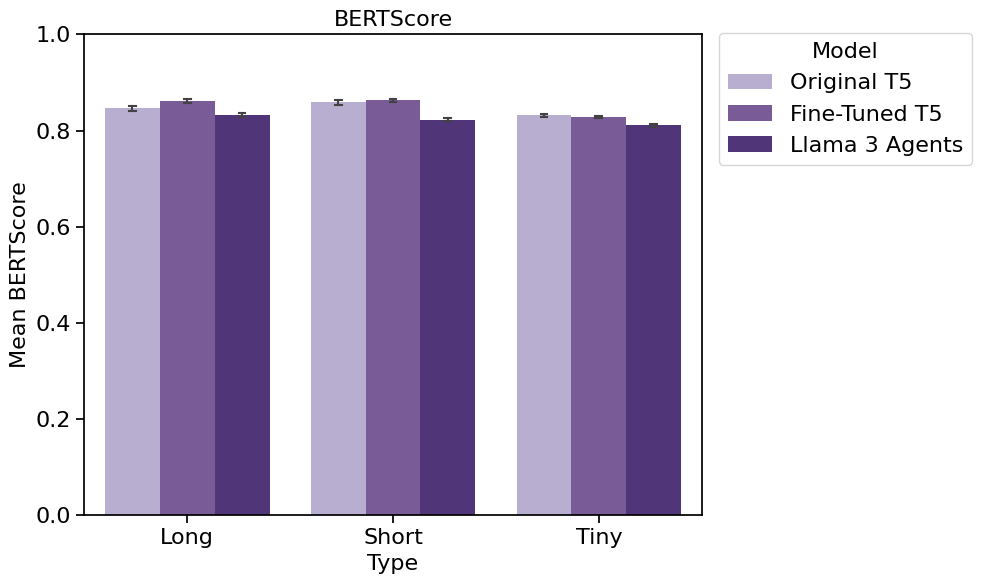

In [38]:
models = {
    'Original T5': original_t5_scores,
    'Fine-Tuned T5': ft_t5_scores,
    'Llama 3 Agents': llama3_scores
}
types = ['long', 'short', 'tiny']
custom_palette = {
    'Original T5': '#b4a8d6',
    'Fine-Tuned T5': '#7951a1',
    'Llama 3 Agents': '#4E2A84'
}

data = []
for model_name, df in models.items():
    for summary_type in types:
        for val in df[f'bert_{summary_type}']:
            data.append({
                'Model': model_name,
                'Type': summary_type.capitalize(),
                'BERT Score': val
            })

df_plot = pd.DataFrame(data)

sns.set_context("notebook")

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_plot,
    x='Type', y='BERT Score', hue='Model',
    palette=custom_palette,
    errorbar=('ci', 95),
    capsize=0.1,
    err_kws={'linewidth': 1.5}
)

plt.title('BERTScore', fontsize=16)
plt.xlabel('Type', fontsize=16)
plt.ylabel('Mean BERTScore', fontsize=16)
plt.ylim(0, 1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(
    title='Model',
    fontsize=16,
    title_fontsize=16,
    loc='upper left',
    bbox_to_anchor=(1.01, 1.025)
)

plt.tight_layout()
plt.show()

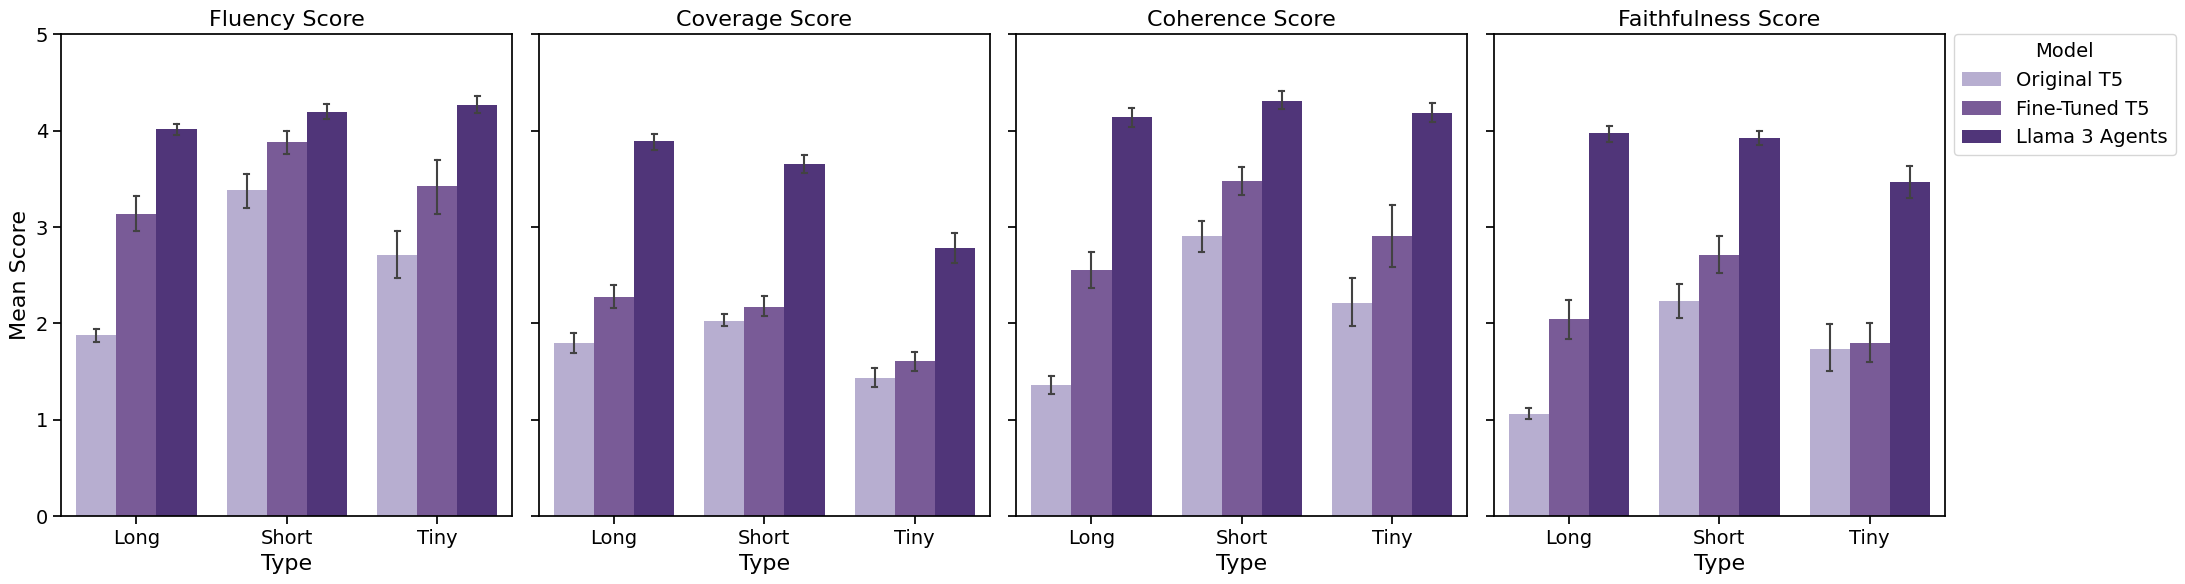

In [39]:
score_keys = [
    ('fluency', 'Fluency Score'),
    ('coverage', 'Coverage Score'),
    ('coherence', 'Coherence Score'),
    ('faithfulness', 'Faithfulness Score')
]

sns.set_context("notebook")

fig, axes = plt.subplots(1, 4, figsize=(22, 6), sharey=True)

for ax, (score_key, score_label) in zip(axes, score_keys):
    data = []
    for model_name, df in models.items():
        for summary_type in types:
            values = df[f'{score_key}_{summary_type}']
            for val in values:
                data.append({
                    'Model': model_name,
                    'Type': summary_type.capitalize(),
                    'Score': val
                })
    df_plot = pd.DataFrame(data)

    sns.barplot(
        data=df_plot, x='Type', y='Score', hue='Model',
        palette=custom_palette, ax=ax, errorbar=('ci', 95),
        capsize=0.1, err_kws={'linewidth': 1.5}
    )

    ax.set_title(f'{score_label}', fontsize=16)
    ax.set_xlabel('Type', fontsize=16)
    if ax == axes[0]:
        ax.set_ylabel('Mean Score', fontsize=16)
    else:
        ax.set_ylabel('')
    ax.set_ylim(0, 5)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    if ax != axes[-1]:
        ax.get_legend().remove()
    else:
        legend = ax.legend(
            title='Model',
            bbox_to_anchor=(1.02, 1),
            loc='upper left',
            borderaxespad=0.,
            fontsize=14,
            title_fontsize=14
        )

plt.tight_layout()
plt.show()


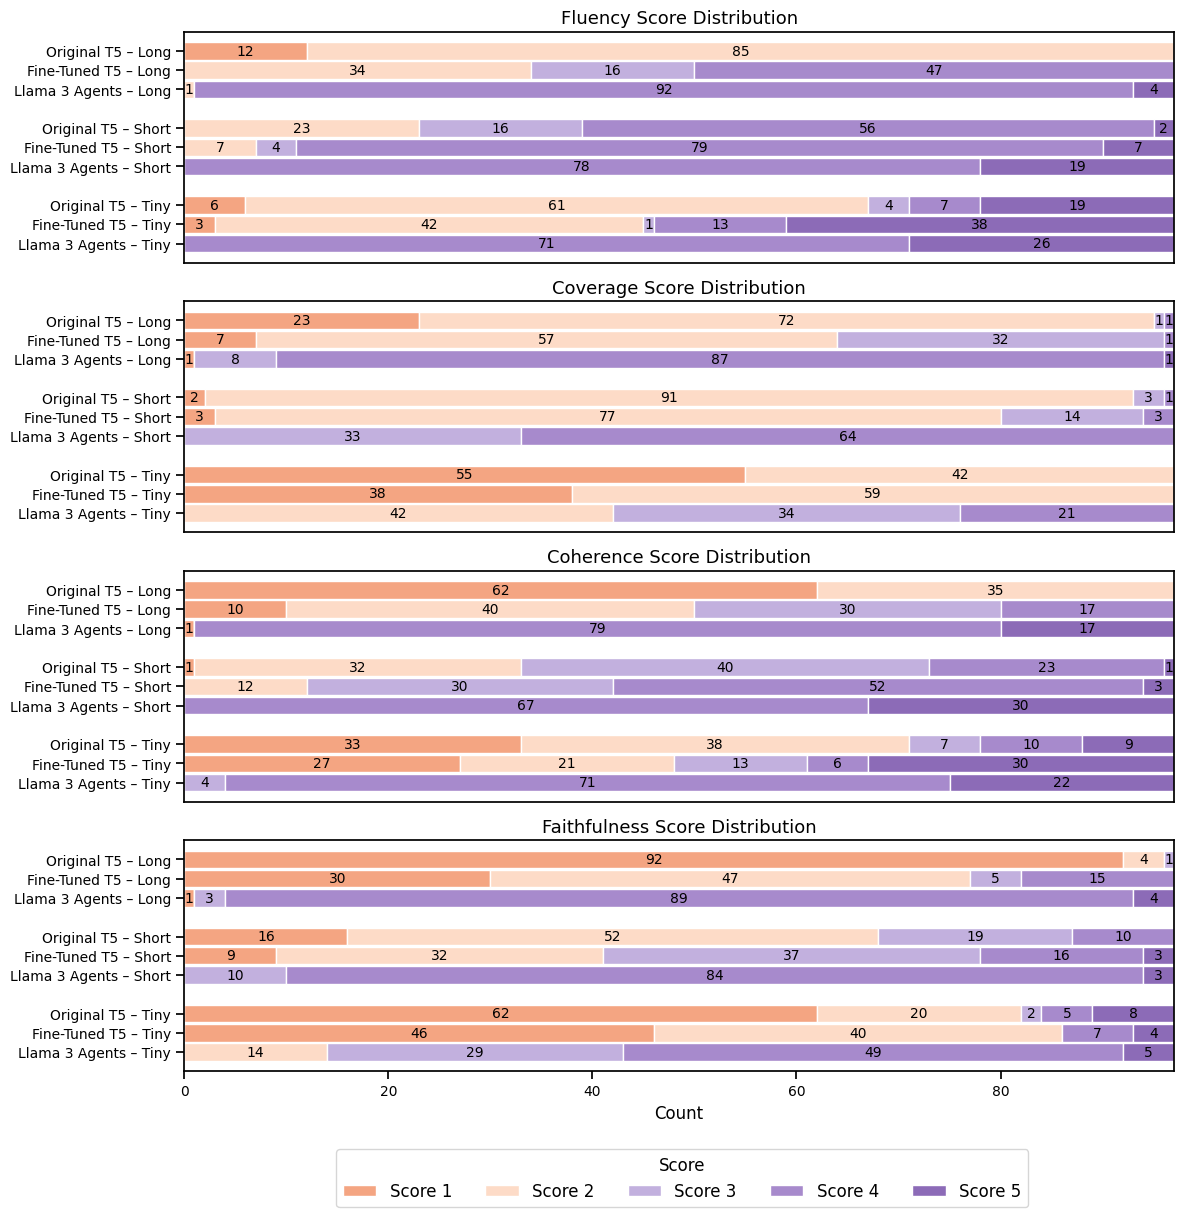

In [40]:
models = {
    "Original T5": original_t5_scores,
    "Fine-Tuned T5": ft_t5_scores,
    "Llama 3 Agents": llama3_scores
}

summary_types = ["long", "short", "tiny"]
dimensions = ["fluency", "coverage", "coherence", "faithfulness"]
score_range = [1, 2, 3, 4, 5]

data = {dim.capitalize(): {stype.capitalize(): [] for stype in summary_types} for dim in dimensions}

for dim in dimensions:
    for stype in summary_types:
        for model_name, df in models.items():
            col = f"{dim}_{stype}"
            counts = df[col].value_counts().reindex(score_range, fill_value=0).tolist()
            data[dim.capitalize()][stype.capitalize()].append(counts)

colors = ['#f4a582', '#fddbc7', '#c2b0de', '#a78acc', '#8c6bb7']
score_labels = ['Score 1', 'Score 2', 'Score 3', 'Score 4', 'Score 5']
model_names = list(models.keys())
summary_types_cap = ['Long', 'Short', 'Tiny']
dimensions_cap = list(data.keys())

max_total = 97
fig, axes = plt.subplots(nrows=len(dimensions_cap), figsize=(12, 12), sharex=True)

for plot_idx, dimension in enumerate(dimensions_cap):
    ax = axes[plot_idx]
    bar_height = 0.25
    yticks = []
    ylabels = []

    for i, stype in enumerate(summary_types_cap):
        for j in range(len(model_names)):
            y = i + j * bar_height
            values = data[dimension][stype][j]
            left = 0
            for k in range(5):  # Score levels
                width = values[k]
                ax.barh(y, width, left=left, height=bar_height * 0.9, color=colors[k], edgecolor='white')
                if width > 0:
                    ax.text(left + width / 2, y, str(width), ha='center', va='center', fontsize=10)
                left += width
            yticks.append(y)
            ylabels.append(f"{model_names[j]} – {stype}")

    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels, fontsize=10)
    ax.set_xlim(0, max_total)
    ax.invert_yaxis()
    ax.set_title(f"{dimension} Score Distribution", fontsize=13)

    if plot_idx == len(dimensions_cap) - 1:
        ax.set_xlabel("Count", fontsize=12)
        ax.tick_params(axis='x', labelsize=10)
    else:
        ax.tick_params(axis='x', bottom=False, labelbottom=False)

fig.legend(score_labels, title="Score", loc='lower left', ncol=5, bbox_to_anchor=(0.28, -0.02), fontsize=12)
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()


In [41]:
def compare_all_scores(models, metrics, types=['long', 'short', 'tiny'], alpha=0.05):
    results = []
    model_names = list(models.keys())
    
    for metric in metrics:
        for summary_type in types:
            col = f"{metric}_{summary_type}"
            for model_a, model_b in itertools.combinations(model_names, 2):
                scores_a = models[model_a][col]
                scores_b = models[model_b][col]
                # Test if A > B
                stat, pval_greater = mannwhitneyu(scores_a, scores_b, alternative='greater')
                # Test if B > A
                stat, pval_less = mannwhitneyu(scores_a, scores_b, alternative='less')
                results.append({
                    "Metric": metric.capitalize(),
                    "Type": summary_type.capitalize(),
                    "Model A": model_a,
                    "Model B": model_b,
                    "A > B p-value": pval_greater,
                    "B > A p-value": pval_less,
                    "A mean": scores_a.mean(),
                    "B mean": scores_b.mean(),
                    "A median": scores_a.median(),
                    "B median": scores_b.median(),
                    "A > B significant": pval_greater < alpha,
                    "B > A significant": pval_less < alpha
                })
    df_results = pd.DataFrame(results)
    return df_results

models = {
    "Original T5": original_t5_scores,
    "Fine-Tuned T5": ft_t5_scores,
    "Llama 3 Agents": llama3_scores
}
metrics = ['fluency', 'coverage', 'coherence', 'faithfulness']

results_df = compare_all_scores(models, metrics)
results_df

,Metric,Type,Model A,Model B,A > B p-value,B > A p-value,A mean,B mean,A median,B median,A > B significant,B > A significant
0,Fluency,Long,Original T5,Fine-Tuned T5,1.000000,4.109636e-22,1.876289,3.134021,2.0,3.0,False,True
1,Fluency,Long,Original T5,Llama 3 Agents,1.000000,1.537875e-40,1.876289,4.020619,2.0,4.0,False,True
2,Fluency,Long,Fine-Tuned T5,Llama 3 Agents,1.000000,8.633055e-16,3.134021,4.020619,3.0,4.0,False,True
3,Fluency,Short,Original T5,Fine-Tuned T5,0.999998,1.949773e-06,3.381443,3.886598,4.0,4.0,False,True
4,Fluency,Short,Original T5,Llama 3 Agents,1.000000,1.042430e-13,3.381443,4.195876,4.0,4.0,False,True
5,Fluency,Short,Fine-Tuned T5,Llama 3 Agents,0.999923,7.857203e-05,3.886598,4.195876,4.0,4.0,False,True
6,Fluency,Tiny,Original T5,Fine-Tuned T5,0.999641,3.626527e-04,2.711340,3.422680,2.0,4.0,False,True
7,Fluency,Tiny,Original T5,Llama 3 Agents,1.000000,4.760057e-15,2.711340,4.268041,2.0,4.0,False,True
8,Fluency,Tiny,Fine-Tuned T5,Llama 3 Agents,0.998002,2.015719e-03,3.422680,4.268041,4.0,4.0,False,True
9,Coverage,Long,Original T5,Fine-Tuned T5,1.000000,3.497641e-09,1.793814,2.278351,2.0,2.0,False,True


In [47]:
def compare_scores_aggregated(models, metrics, types=['long', 'short', 'tiny'], alpha=0.05):
    results = []
    model_names = list(models.keys())
    for metric in metrics:
        # For each model, concatenate all summary types for this metric
        model_scores = {
            model_name: pd.concat([
                df[f'{metric}_{summary_type}'].dropna() for summary_type in types
            ], ignore_index=True)
            for model_name, df in models.items()
        }
        for model_a, model_b in itertools.combinations(model_names, 2):
            scores_a = model_scores[model_a]
            scores_b = model_scores[model_b]
            # Test if A > B
            stat, pval_greater = mannwhitneyu(scores_a, scores_b, alternative='greater')
            # Test if B > A
            stat, pval_less = mannwhitneyu(scores_a, scores_b, alternative='less')
            results.append({
                "Metric": metric.capitalize(),
                "Model A": model_a,
                "Model B": model_b,
                "A > B p-value": pval_greater,
                "B > A p-value": pval_less,
                "A mean": scores_a.mean(),
                "B mean": scores_b.mean(),
                "A median": scores_a.median(),
                "B median": scores_b.median(),
                "A > B significant": pval_greater < alpha,
                "B > A significant": pval_less < alpha
            })
    df_results = pd.DataFrame(results)
    numeric_cols = [
        "A mean", "B mean",
        "A median", "B median"
    ]
    df_results[numeric_cols] = df_results[numeric_cols].round(4)
    return df_results

models = {
    "Original T5": original_t5_scores,
    "Fine-Tuned T5": ft_t5_scores,
    "Llama 3 Agents": llama3_scores
}
metrics = ['fluency', 'coverage', 'coherence', 'faithfulness']

results_df = compare_scores_aggregated(models, metrics)
results_df

,Metric,Model A,Model B,A > B p-value,B > A p-value,A mean,B mean,A median,B median,A > B significant,B > A significant
0,Fluency,Original T5,Fine-Tuned T5,1.0,1.057953e-17,2.6564,3.4811,2.0,4.0,False,True
1,Fluency,Original T5,Llama 3 Agents,1.0,1.068750e-55,2.6564,4.1615,2.0,4.0,False,True
2,Fluency,Fine-Tuned T5,Llama 3 Agents,1.0,2.764822e-15,3.4811,4.1615,4.0,4.0,False,True
3,Coverage,Original T5,Fine-Tuned T5,1.0,1.659052e-08,1.7526,2.0206,2.0,2.0,False,True
4,Coverage,Original T5,Llama 3 Agents,1.0,1.026022e-83,1.7526,3.4467,2.0,4.0,False,True
5,Coverage,Fine-Tuned T5,Llama 3 Agents,1.0,1.304788e-68,2.0206,3.4467,2.0,4.0,False,True
6,Coherence,Original T5,Fine-Tuned T5,1.0,3.017125e-16,2.1615,2.9794,2.0,3.0,False,True
7,Coherence,Original T5,Llama 3 Agents,1.0,1.055738e-76,2.1615,4.2131,2.0,4.0,False,True
8,Coherence,Fine-Tuned T5,Llama 3 Agents,1.0,1.326584e-40,2.9794,4.2131,3.0,4.0,False,True
9,Faithfulness,Original T5,Fine-Tuned T5,1.0,5.278079e-12,1.6770,2.1856,1.0,2.0,False,True
